In [3]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

## Optiver Realized Volatility Prediction

## 1. Introduction

This competition's objective is predicting short-term volatility for 112 stocks across different sectors. Dataset consist book and trade data of the stocks for multiple time buckets. We are supposed to predict a target value (volatility) for every time bucket of the stocks. 107 of the stocks have 3830, 3 of the stocks have 3829, 1 of the stocks has 3820 and 1 of the stocks has 3815 time buckets in training dataset. Thus, there are 428,932 rows to predict in it. Since this is a code competition, public test set is hidden and private test set will be real market data collected in the three-month evaluation period after competition ends. There are 3 columns in training set and 2 columns in placeholder test set.

* `stock_id` - ID of the stock
* `time_id` - ID of the time bucket
* `target` - Realized volatility of the next 10 minute window under the same stock_id/time_id (doesn't exist in placeholder test set)

In [5]:
train_test_dtypes = {
    'stock_id': np.uint8,
    'time_id': np.uint16,
    'target': np.float64
}

df_train = pd.read_csv('~/Documents/deep-learning/quant_course/kaggle_volatility/optiver-realized-volatility-prediction/train.csv', dtype=train_test_dtypes)
df_test = pd.read_csv('~/Documents/deep-learning/quant_course/kaggle_volatility/optiver-realized-volatility-prediction/test.csv', usecols=['stock_id', 'time_id'], dtype=train_test_dtypes)

print(f'Training Set Shape: {df_train.shape}')
print(f'Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape}')
print(f'Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

FileNotFoundError: [Errno 2] No such file or directory: '/optiver-realized-volatility-prediction/train.csv'

## 2. Evaluation

Submissions are scored using RMSPE (root mean squared percentage error) which can be denoted as

$\huge \text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ((y_i - \hat{y}_i)/y_i)^2}$

RMSPE is very similar to RMSE. The only difference between them is, the error is divided by the actual value. Predictions closer to actual values yield errors closer to 0, so division by actual values is sensitive to larger errors. In addition to that, errors are squared before they are averaged, which makes this metric even more sensitive to larger errors. This means larger errors are not tolerable in this domain.

One pitfall of RMSPE is it can raise ZeroDivisionError if a single data point in actual values is equal to 0. Even though, there isn't any 0 target values in training set, this can be easily solved by adding a small constant to actual values. A small constant epsilon wouldn't contribute to overall rmspe and it prevents ZeroDivisionError.

For baselines, global target mean scores **1.11033**, target mean of stock_ids scores **0.789618**, and target median of stock_ids scores **0.589135**  on training set.

In [3]:
def root_mean_squared_percentage_error(y_true, y_pred, epsilon=1e-10):
    
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + epsilon))))
    return rmspe


target_mean_rmspe = root_mean_squared_percentage_error(df_train['target'], np.repeat(df_train['target'].mean(), len(df_train)))
print(f'target Mean RMPSE: {target_mean_rmspe:.6}')

stock_id_target_mean_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train.groupby('stock_id')['target'].transform('mean'))
print(f'stock_id target Mean RMPSE: {stock_id_target_mean_rmspe:.6}')

stock_id_target_median_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train.groupby('stock_id')['target'].transform('median'))
print(f'stock_id target Median RMPSE: {stock_id_target_median_rmspe:.6}')

target Mean RMPSE: 1.11033
stock_id target Mean RMPSE: 0.789618
stock_id target Median RMPSE: 0.589135


## 3. Realized Volatility (Target)

Target is defined as realized volatility computed over the 10 minute window following the feature data under the same stock/time_id. For every stock_id and its time_id, target is the next 10 minute realized volatility of the same stock_id and time_id. Thus, there are 10 minute gaps between provided dataset and target values, and there is no overlap between them.

Realized volatility, $\sigma$, is the squared root of the sum of squared log returns which is denoted as

$\huge \sigma = \sqrt{\sum_{t}r_{t-1, t}^2}$

and log return of a stock $S$ at time $t$ is

$\huge r_{t-1, t} = \log \left( \frac{S_{t-1}}{S_{t1}} \right)$

where $S_t$ is the prize of the stock $S$ at time $t$. The price used for targets is the weighted averaged price (WAP) and it can be derived from book data. Log returns are used for realized volatility calculation because price differences are not always comparable across stocks.

In [4]:
def visualize_target(target):
    
    print(f'{target}\n{"-" * len(target)}')
        
    print(f'Mean: {df_train[target].mean():.4f}  -  Median: {df_train[target].median():.4f}  -  Std: {df_train[target].std():.4f}')
    print(f'Min: {df_train[target].min():.4f}  -  25%: {df_train[target].quantile(0.25):.4f}  -  50%: {df_train[target].quantile(0.5):.4f}  -  75%: {df_train[target].quantile(0.75):.4f}  -  Max: {df_train[target].max():.4f}')
    print(f'Skew: {df_train[target].skew():.4f}  -  Kurtosis: {df_train[target].kurtosis():.4f}')
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} ({missing_values_count * 100 / training_samples_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 8), dpi=100)
    sns.kdeplot(df_train[target], label=target, fill=True, ax=axes[0])
    axes[0].axvline(df_train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    probplot(df_train[target], plot=axes[1])
    axes[0].legend(prop={'size': 16})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5, pad=10)
        axes[i].tick_params(axis='y', labelsize=12.5, pad=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    axes[0].set_title(f'{target} Distribution in Training Set', fontsize=20, pad=15)
    axes[1].set_title(f'{target} Probability Plot', fontsize=20, pad=15)

    plt.show()


Distribution of target is highly right-skewed and there are extreme outliers since some of the stocks are very volatile. Those extreme outliers can be spotted on the probability plot.

target
------
Mean: 0.0039  -  Median: 0.0030  -  Std: 0.0029
Min: 0.0001  -  25%: 0.0020  -  50%: 0.0030  -  75%: 0.0047  -  Max: 0.0703
Skew: 2.8226  -  Kurtosis: 14.9611
Missing Values: 0/428932 (0.0000%)


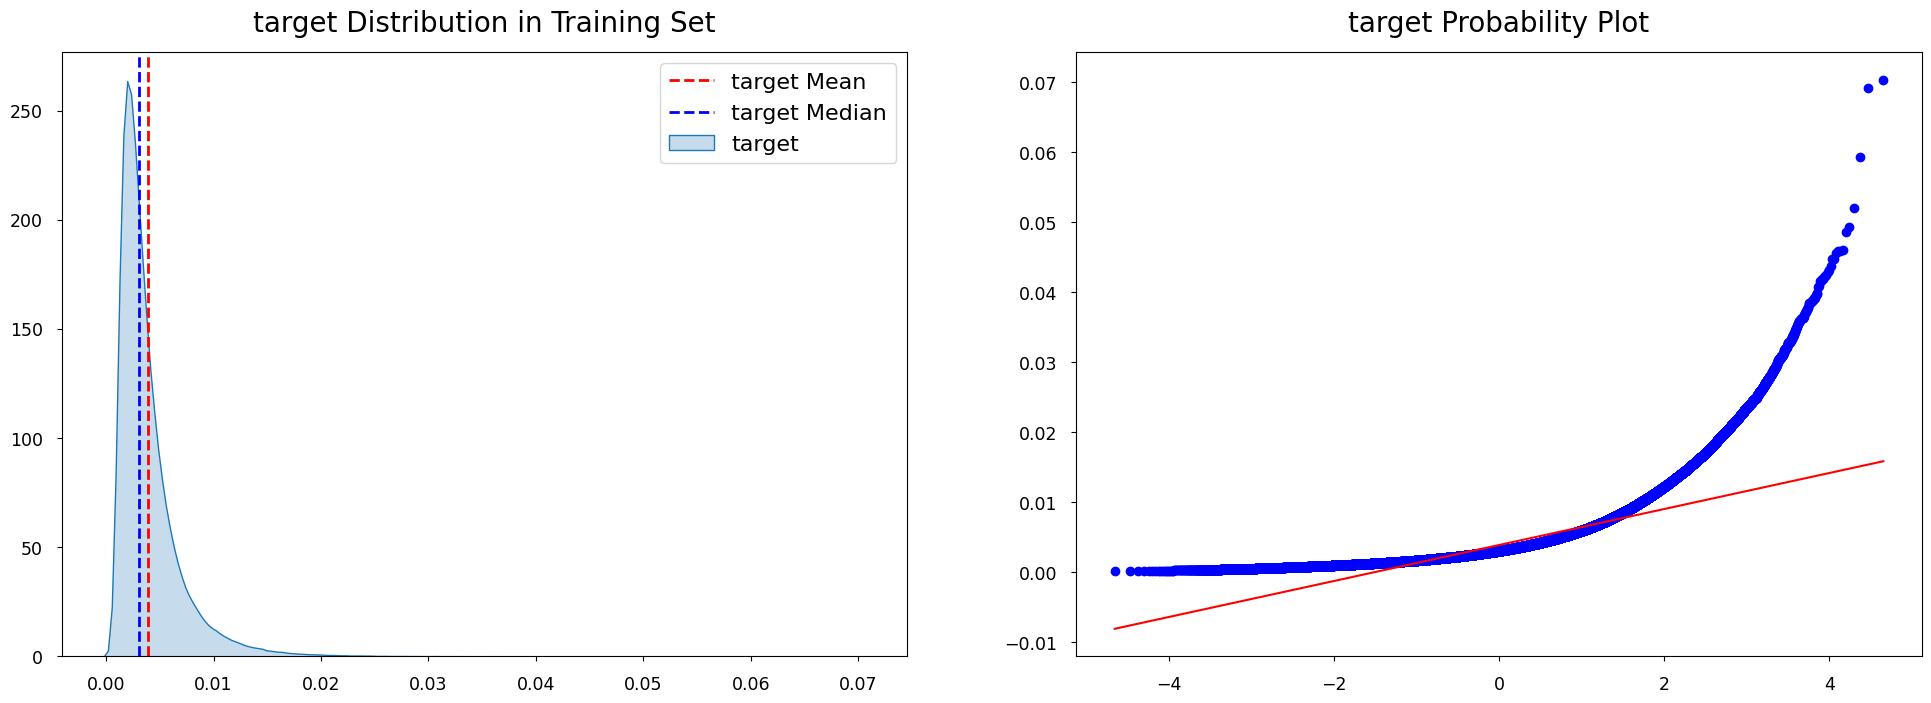

In [5]:
visualize_target('target')

Each stock is very different in terms of volatility. Stocks are displayed below from most volatile to least volatile. They are ranked by their mean target value across multiple time_ids. Wide error bars show that even the realized volatility is volatile between multiple time buckets. One stock can be extremely volatile in one time bucket and less volatile in another time bucket. This phenomenon can be explained by time_ids not being sequential, and there aren't any temporal dependencies between them.

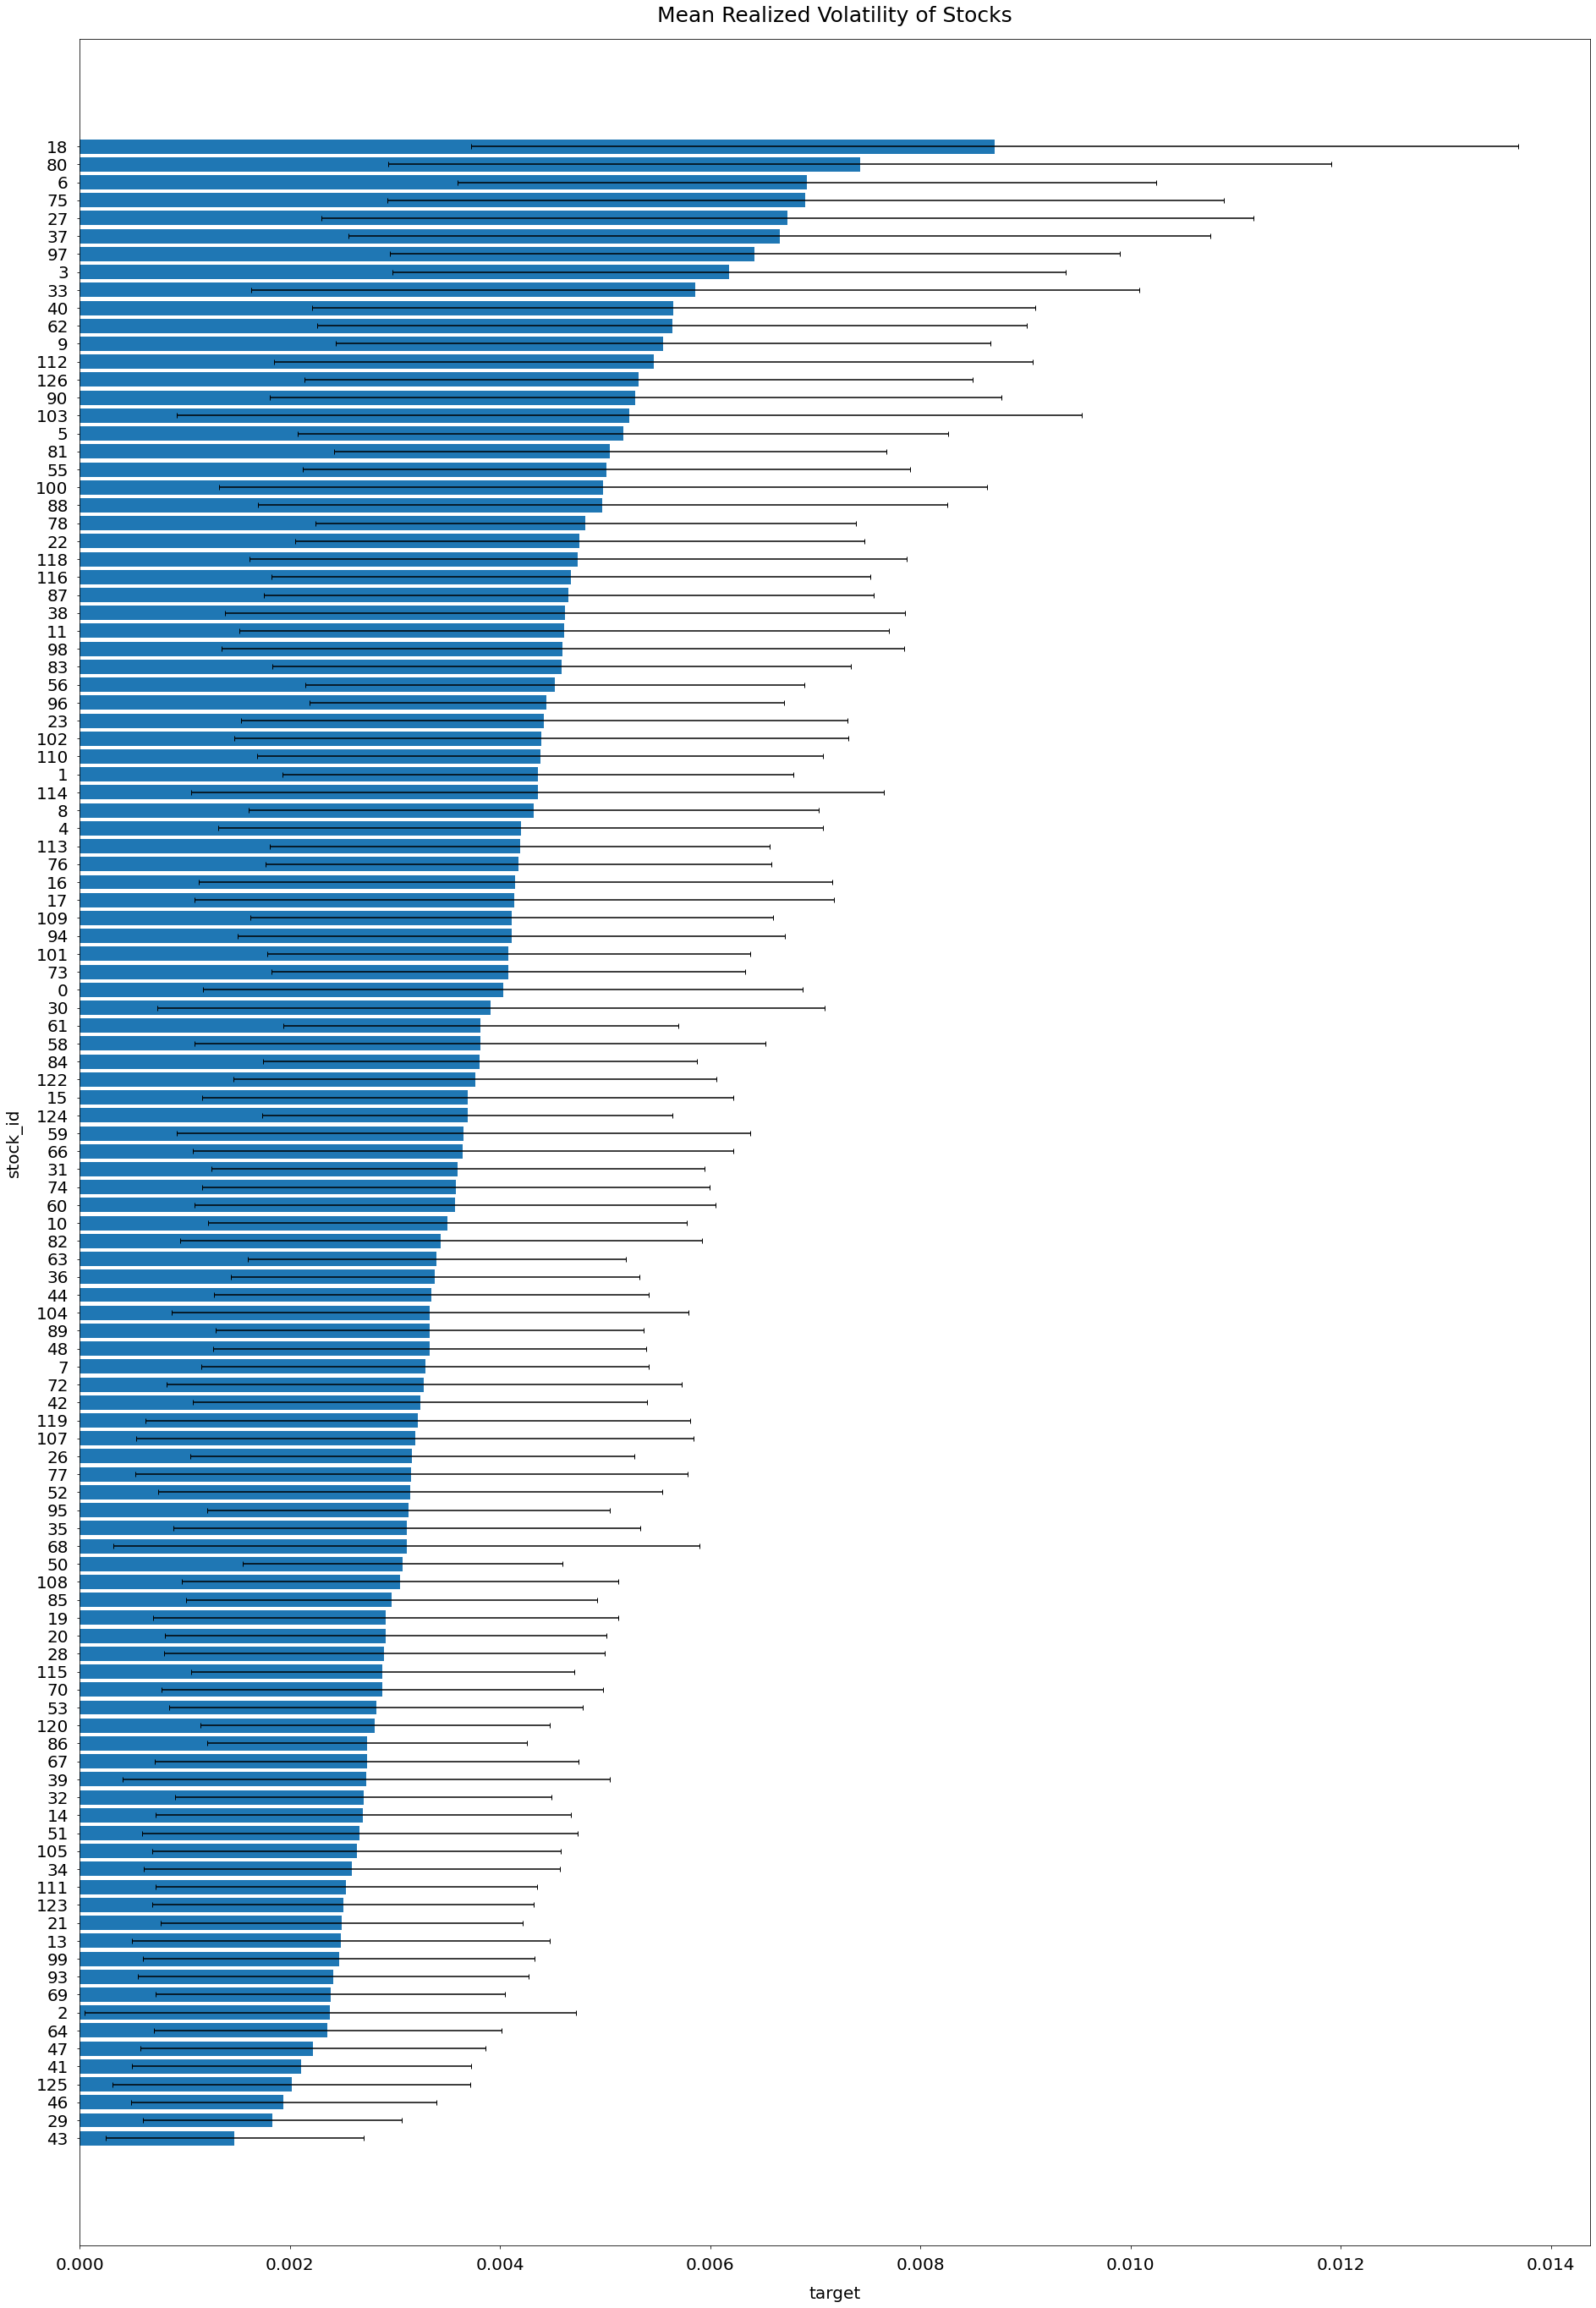

In [6]:
target_means = df_train.groupby('stock_id')['target'].mean()
target_stds = df_train.groupby('stock_id')['target'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds

Instead of entire stocks, individual time buckets from different stocks are ranked based on their realized volatility. The most volatile 10 time buckets can be seen below. The most volatile time bucket belongs to stock 77 and its time_id is 24600. The most volatile stock was stock 18 and it has 3 time buckets in this list.

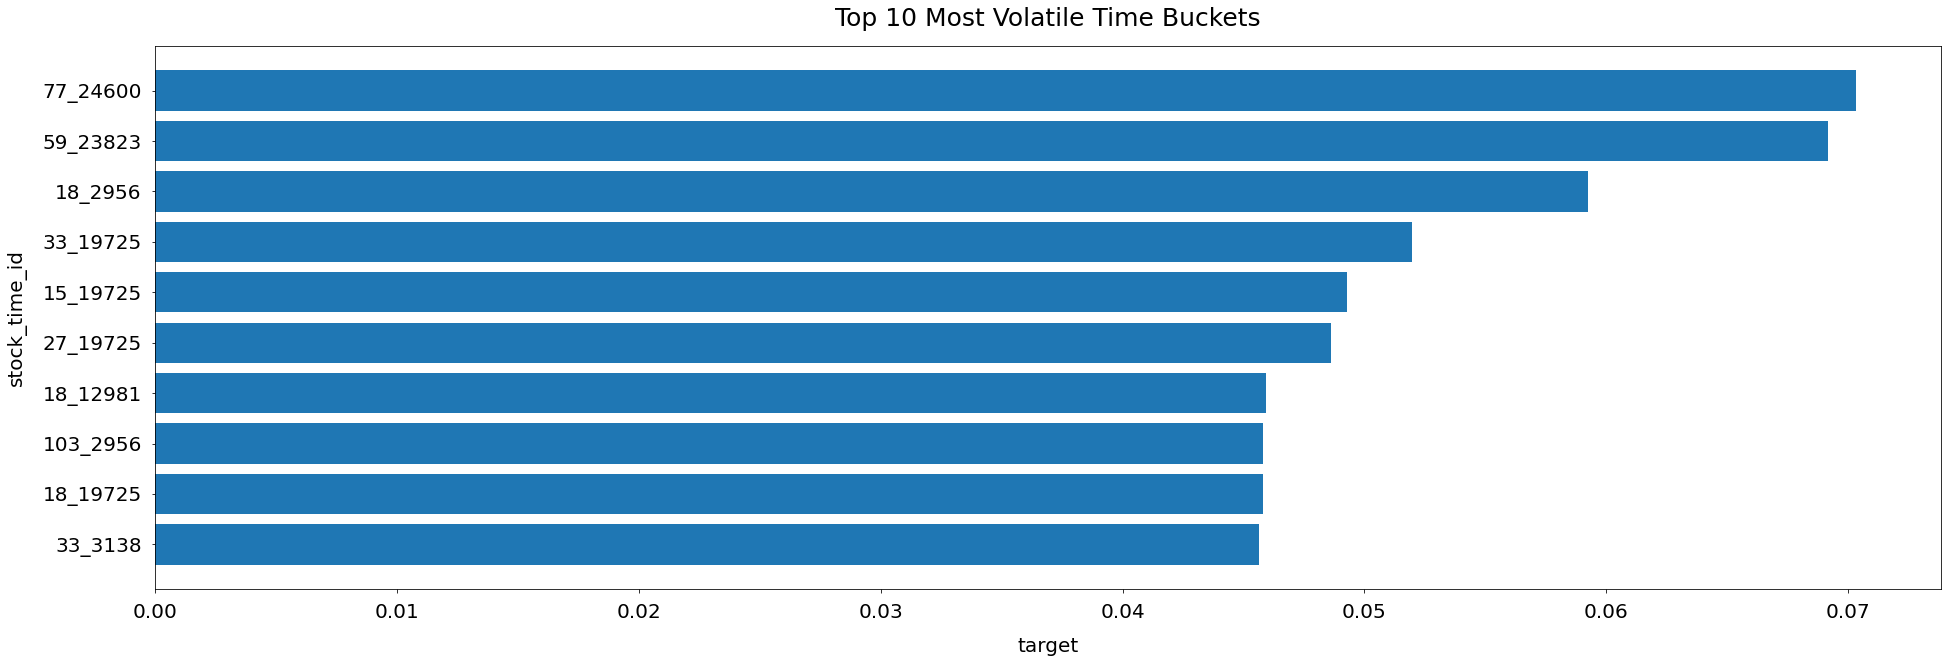

In [7]:
df_train['stock_time_id'] = df_train['stock_id'].astype(str) + '_' + df_train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=df_train.sort_values(by='target', ascending=True).tail(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(df_train.sort_values(by='target', ascending=True).tail(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Most Volatile Time Buckets', size=25, pad=20)

plt.show()

df_train.drop(columns=['stock_time_id'], inplace=True)

The least volatile 10 time buckets are also visualized and they can be seen below. All of the least volatile 10 time buckets belong to stock 31, even though it has an average volatility overall. This could be an anomaly and it must be explored further.

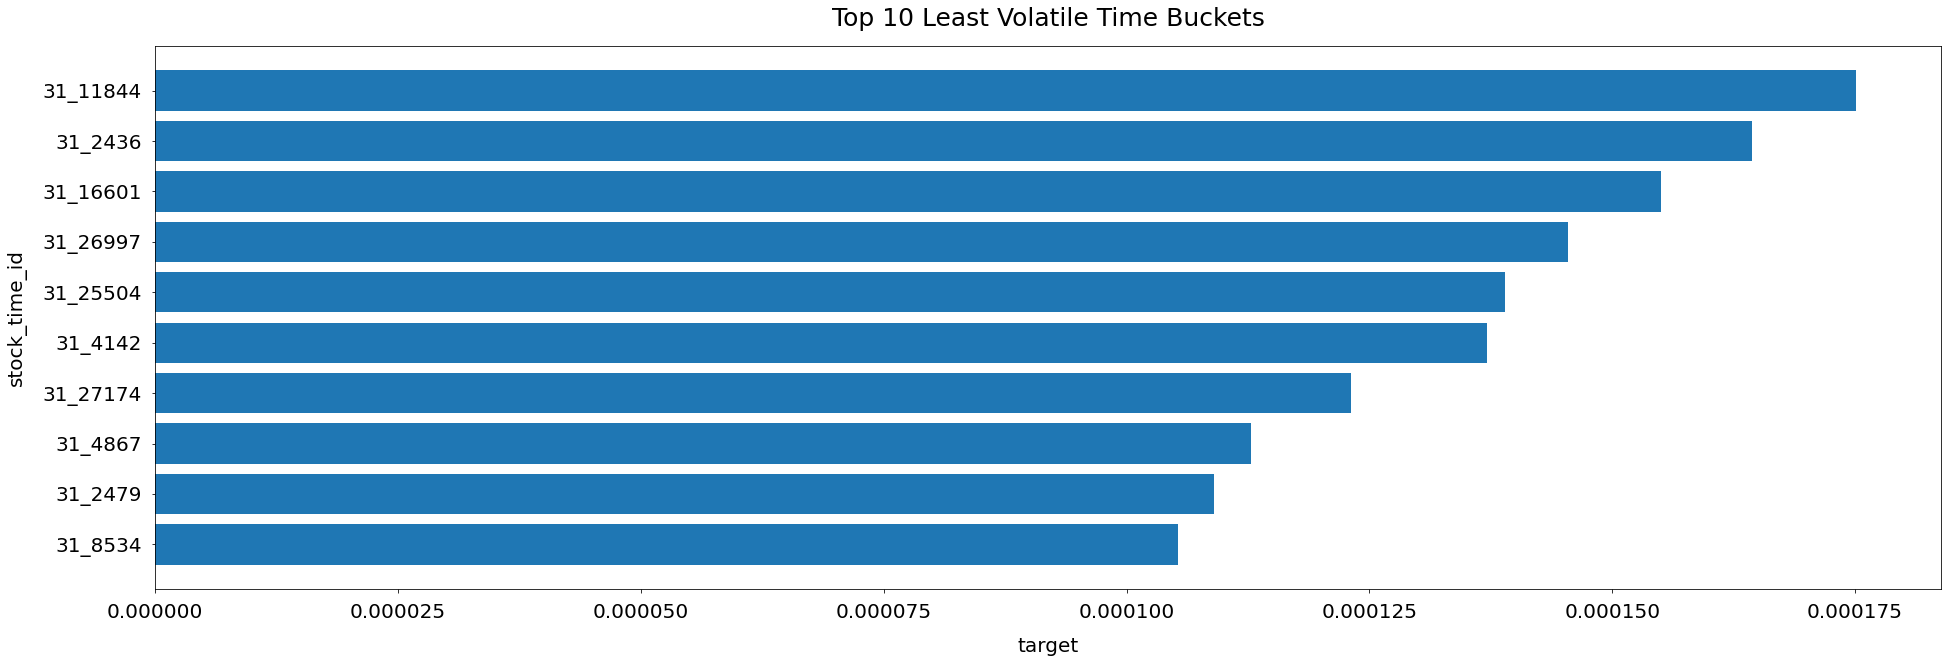

In [8]:
df_train['stock_time_id'] = df_train['stock_id'].astype(str) + '_' + df_train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=df_train.sort_values(by='target', ascending=True).head(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(df_train.sort_values(by='target', ascending=True).head(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Least Volatile Time Buckets', size=25, pad=20)

plt.show()

df_train.drop(columns=['stock_time_id'], inplace=True)

## 4. Order Book

Order book is a list of buy and sell orders organized by price level for given stocks. An order book lists the number of shares being bid on or asked at each price point. Order books help to improve market transparency as they provide information on price, availability and depth of trade.

Order book data files are named as `book_train.parquet` and `book_test.parquet`, and they are parquet files partitioned by stock_id column. Partitioned by stock_id means those files can both read as whole or individual stocks. However, reading them as a single file is not easy as they will consume too much memory.

There are 10 columns in every book data partition. The columns are:

* `time_id` - ID of the time bucket
* `seconds_in_bucket` - Number of seconds passed since the start of the bucket
* `bid_price1` - Highest buy price after normalization
* `ask_price1` - Lowest sell price after normalization
* `bid_price2` - Second highest buy price after normalization
* `ask_price2` - Second lowest sell price after normalization
* `bid_size1` - Number of shares on the highest buy price
* `ask_size1` - Number of shares on the lowest sell price
* `bid_size2` - Number of shares on the second highest buy price
* `ask_size2` - Number of shares on the second lowest sell price

Values in order book are the last snapshots of each second. Some of the seconds are not available because there weren't any related market activities during those seconds, thus order books are not updated. Normally, given order books last 600 seconds for every time bucket. Values of the missing seconds are the values at the last updated second, so the book data can be reindexed to 600 seconds for every time bucket and missing values can be forward filled for every field. Forward filling and sorting order books by time_id and seconds_in_bucket doesn't change the extracted features but these functionalities can be added for private test set as a sanity check.

In [9]:
def read_book_data(dataset, stock_id, sort=False, forward_fill=False):
        
    book_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'bid_price1': np.float32,
        'ask_price1': np.float32,
        'bid_price2': np.float32,
        'ask_price2': np.float32,
        'bid_size1': np.uint32,
        'ask_size1': np.uint32,
        'bid_size2': np.uint32,
        'ask_size2': np.uint32,
    }

    df_book = pd.read_parquet(f'~/Documents/deep-learning/quant_course/kaggle_volatility/optiver-realized-volatility-prediction/book_{dataset}.parquet/stock_id={stock_id}')
    for column, dtype in book_dtypes.items():
        df_book[column] = df_book[column].astype(dtype)
    
    if sort:
        df_book.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)
        
    if forward_fill:
        df_book = df_book.set_index(['time_id', 'seconds_in_bucket'])
        df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']), method='ffill')
        df_book.reset_index(inplace=True)

    return df_book


As mentioned, realized volatilities are calculated from the weighted averaged price in order books of every stock. The formula for weighted averaged price is

$\huge WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}}$

Realized volatilities are calculated using the most competitive buy and sell levels, but same formula can applied to second most competitive buy and sell levels or other prices/sizes as well. After that, log returns of the weighted averaged price are summed and square rooted for realized volatility calculation.

In [10]:
for stock_id in tqdm(sorted(df_train['stock_id'].unique())):
            
    df_book = read_book_data('train', stock_id)

    # Weighted averaged prices
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])

    # Realized volatilities
    for wap in [1, 2]:
        df_book[f'log_return_from_wap{wap}'] = np.log(df_book[f'wap{wap}'] / df_book.groupby('time_id')[f'wap{wap}'].shift(1))
        df_book[f'squared_log_return_from_wap{wap}'] = df_book[f'log_return_from_wap{wap}'] ** 2
        df_book[f'realized_volatility_from_wap{wap}'] = np.sqrt(df_book.groupby('time_id')[f'squared_log_return_from_wap{wap}'].transform('sum'))
        df_book.drop(columns=[f'squared_log_return_from_wap{wap}'], inplace=True)            
        realized_volatilities = df_book.groupby('time_id')[f'realized_volatility_from_wap{wap}'].first().to_dict()
        df_train.loc[df_train['stock_id'] == stock_id, f'realized_volatility_from_wap{wap}'] = df_train[df_train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)


  0%|          | 0/112 [00:00<?, ?it/s]

Realized volatilies calculated in the cell above belongs to current 10 minute window. They can be used as baseline predictions. Realized volatilities calculated from WAP1 scores **0.341354** and realized volatilities calculated from WAP2 scores **0.705453** on training set. They should be used as predictors in models since realized volatilities of the current 10 minute window is very valuable information. Targets are most likely be closer to those values.

In [11]:
realized_volatility_wap1_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train['realized_volatility_from_wap1'])
print(f'Realized Volatility from WAP1 RMPSE: {realized_volatility_wap1_rmspe:.6}')
realized_volatility_wap2_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train['realized_volatility_from_wap2'])
print(f'Realized Volatility from WAP2 RMPSE: {realized_volatility_wap2_rmspe:.6}')

Realized Volatility from WAP1 RMPSE: 0.341354
Realized Volatility from WAP2 RMPSE: 0.705453


The order book helps traders to make more informed trading decisions by showing order imbalances that may provide clues to a stock’s direction in the very short term. A huge imbalance of buy orders against sell orders may indicate a move higher in the stock due to buying pressure, or vice versa. Traders can also use the order book to help pinpoint a stock’s potential support and resistance levels. A cluster of large buy orders at a specific price may indicate a level of support, while an abundance of sell orders at or near one price may suggest an area of resistance.
Realized volatilities increase when those moves in either directions become more frequent. The function in the cell below is going to be used for visualizing individual order book time buckets and trying to find clues about their volatilities.

In [12]:
def visualize_book_time_bucket(stock_id, time_id):
    
    time_bucket = (df_train['stock_id'] == stock_id) & (df_train['time_id'] == time_id)
    
    target = df_train.loc[time_bucket, 'target'].iloc[0]
    realized_volatility = df_train.loc[time_bucket, 'realized_volatility_from_wap1'].iloc[0]
    df_book = read_book_data('train', stock_id, sort=True, forward_fill=True)
    df_book = df_book.set_index('seconds_in_bucket')
    
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])
    
    fig, axes = plt.subplots(figsize=(32, 30), nrows=2)
    
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price1'], label='bid_price1', lw=2, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price1'], label='ask_price1', lw=2, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price2'], label='bid_price2', alpha=0.3, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price2'], label='ask_price2', alpha=0.3, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap1'], label='wap1', lw=2, linestyle='--', color='tab:blue')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap2'], label='wap2', alpha=0.3, linestyle='--',  color='tab:blue')
    
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size1'], label='bid_size1', lw=2, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size1'], label='ask_size1', lw=2, color='tab:red')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size2'], label='bid_size2', alpha=0.3, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size2'], label='ask_size2', alpha=0.3, color='tab:red')
    
    for i in range(2):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Prices of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Sizes of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    
    plt.show()


The most volatile time bucket in next 10 minute window is time **24600** from stock **77**. Current realized volatility of that time bucket is 0.02 which is roughly greater than 99.7% of other current realized volatilities. The time bucket was extremely volatile in current 10 minute window and it became the most volatile time bucket in next 10 minute window. Short-term realized volatilities are definitely correlated in this case. First of all, this time bucket is on a decreasing trend because large amount of most competitive ask sizes are always dominating most competitive bid sizes. Some traders were trying to sell lots of shares at most competitive price very frequently. In addition to that, this time bucket has more updates compared to others. Update frequency of time buckets might be correlated to realized volatility since more squared log return values greater than 0 will be summed.

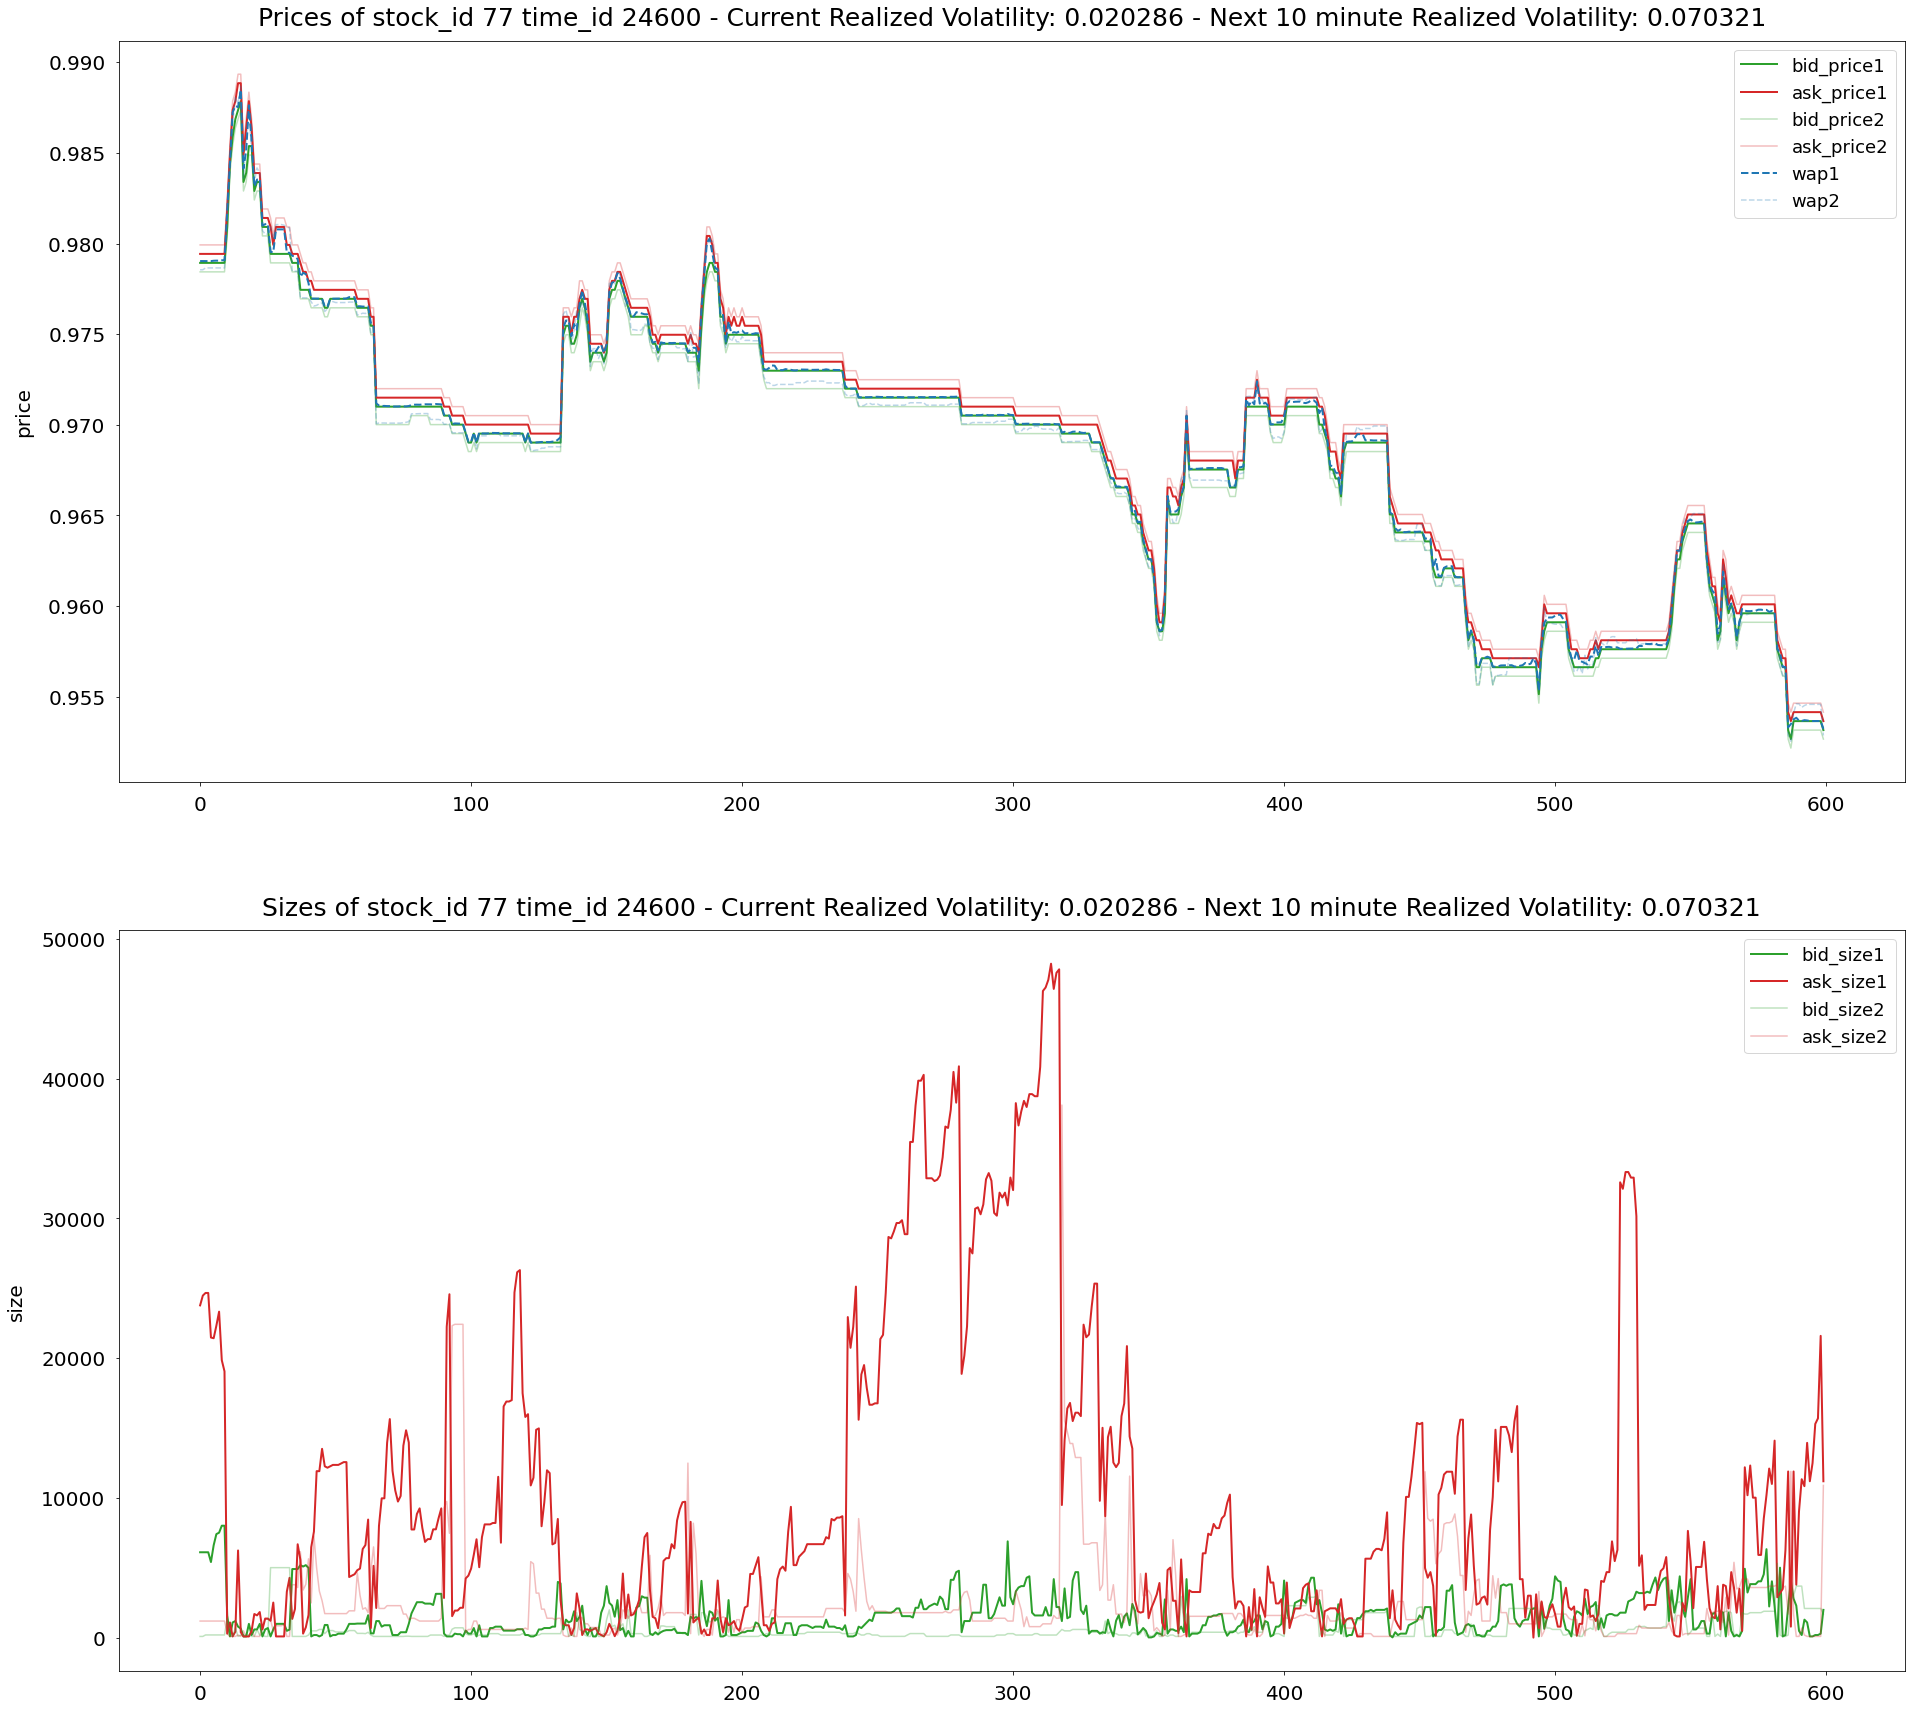

In [13]:
visualize_book_time_bucket(stock_id=77, time_id=24600)

The most volatile time bucket in current 10 minute window is time **30128** from stock **30**. Realized volatility of the next 10 minute window for this time bucket is 0.039 which is roughly greater than %99.994 of other target values. In this case, this time bucket became less volatile in next 10 minute window and that suggests it is really hard to tell whether the realized volatility will be more or less in short-term, but it is expected to be closer to current realized volatility. This stock was extremely volatile in this time bucket because large amount of sell orders at most competitive prize dominated buy orders in first quarter and the opposite happened in second quarter. Later, buy/sell order domination kept switching places in smaller scales and that caused smaller spikes in weigted averaged price 1.

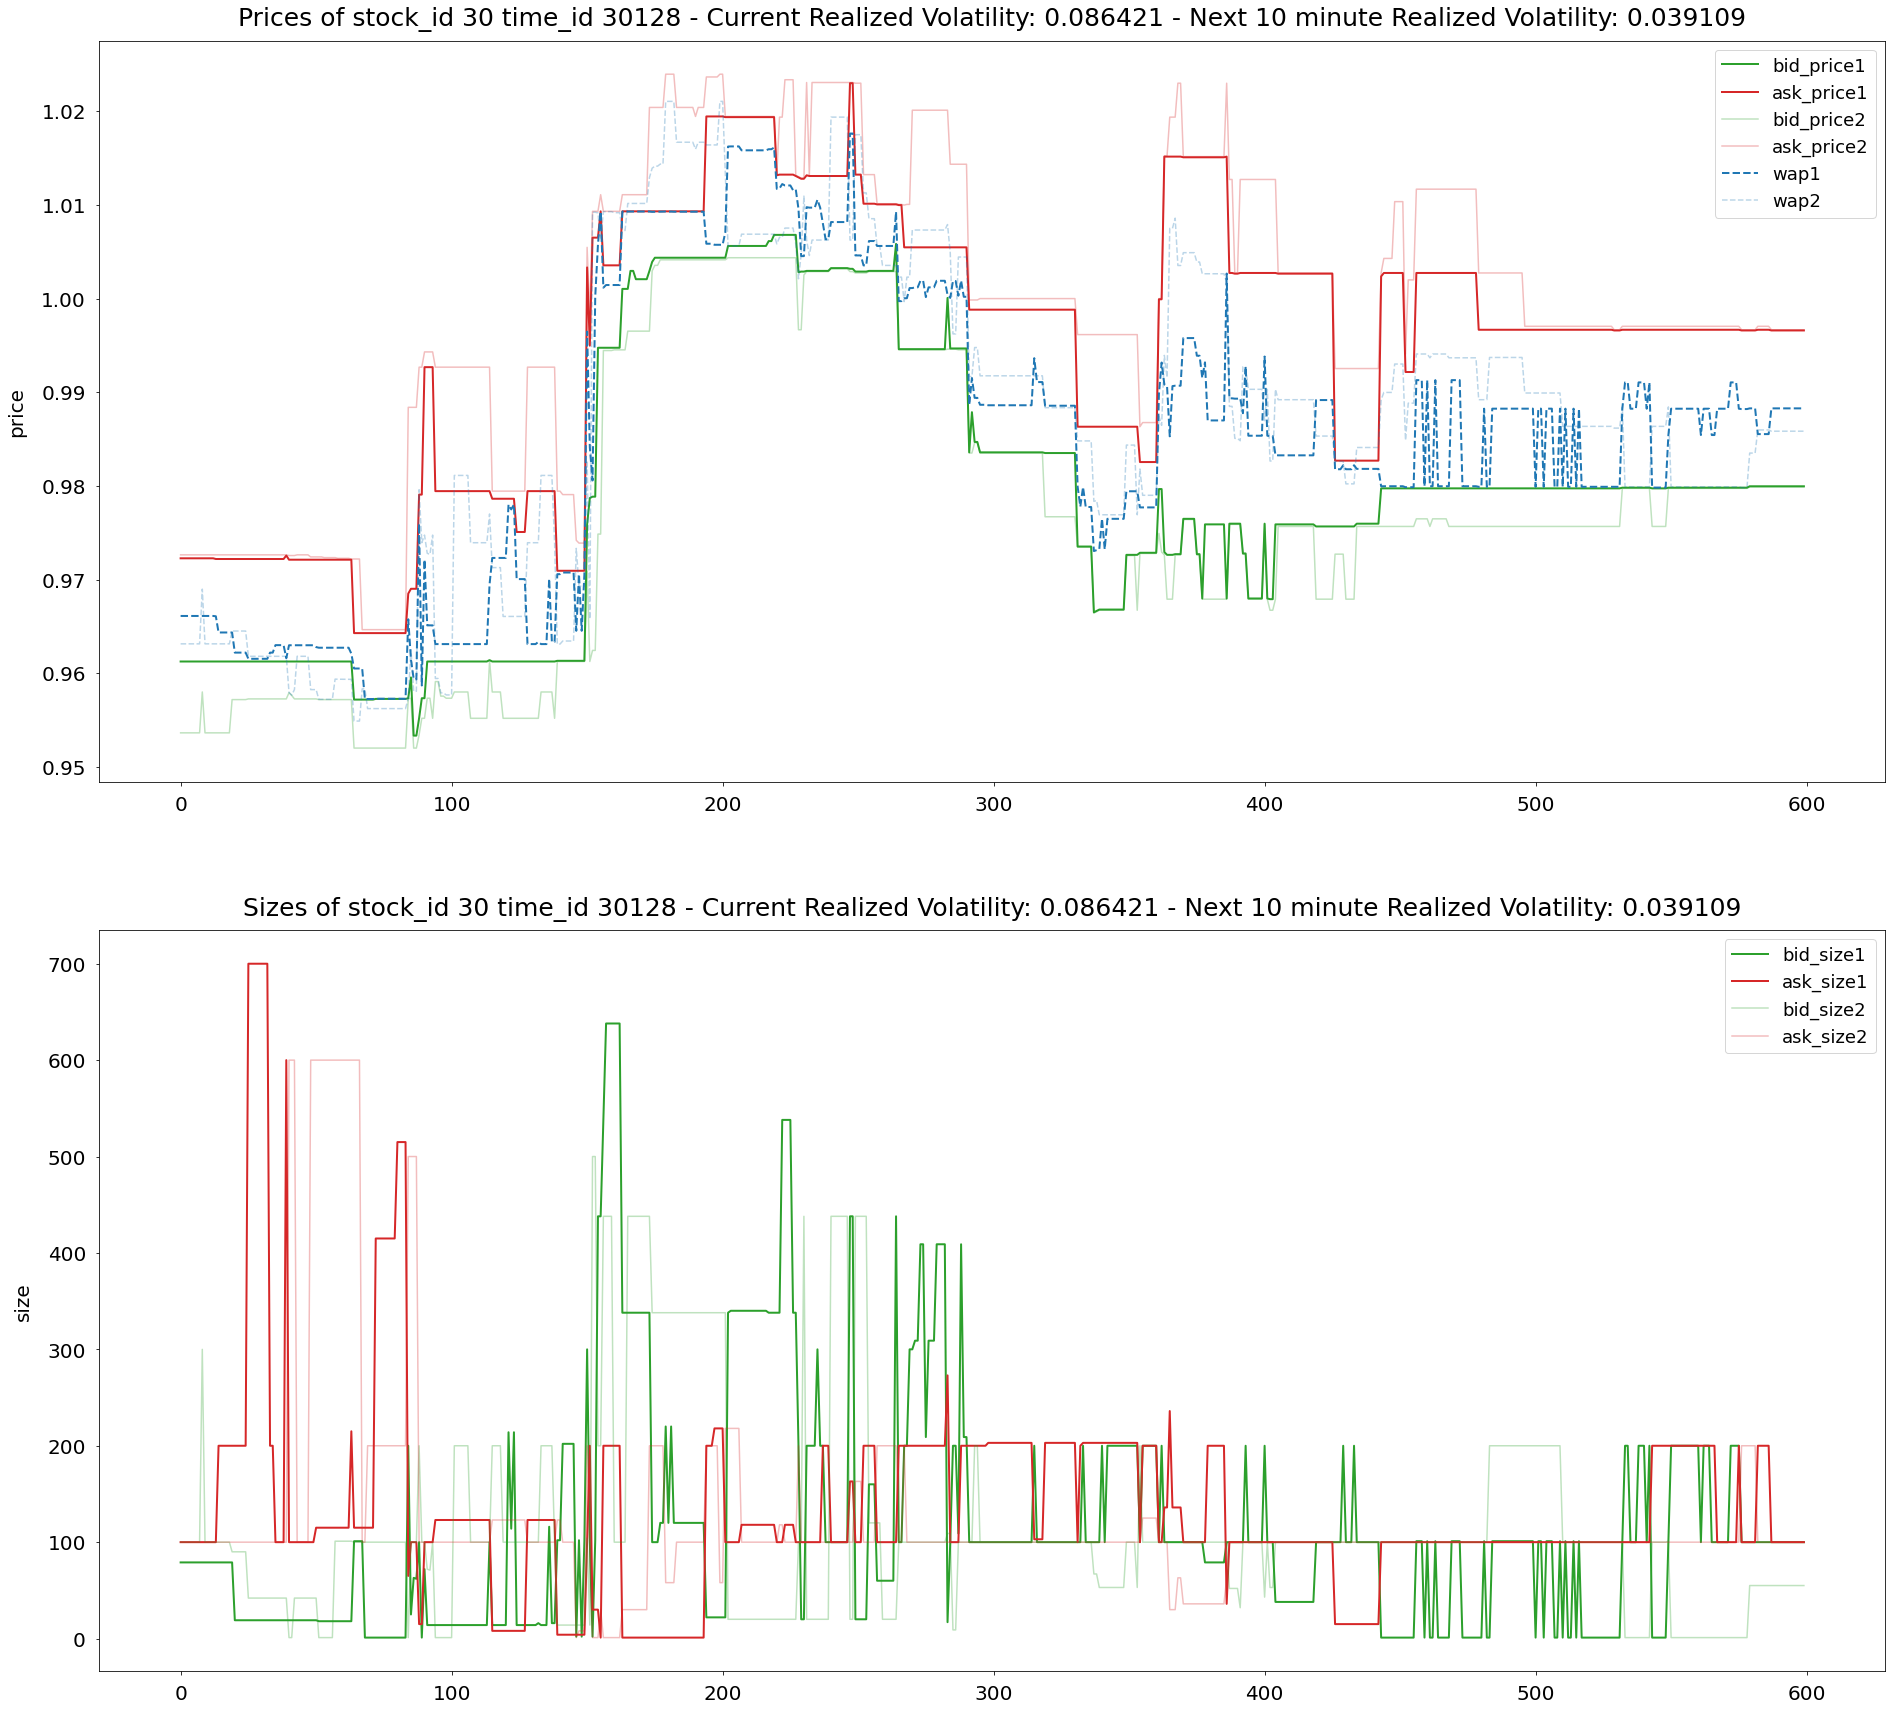

In [14]:
visualize_book_time_bucket(stock_id=30, time_id=30128)

The least volatile time bucket in next 10 minute window is time **8534** from stock **31**. The sizes of most competitive bid and ask orders were always balanced until the very end. Couple changes at the end caused a small decrease and increase in weighted average price 1. That was the only significant contribution to current realized volatility. This time bucket became almost 20 times less volatile in next 10 minute window.

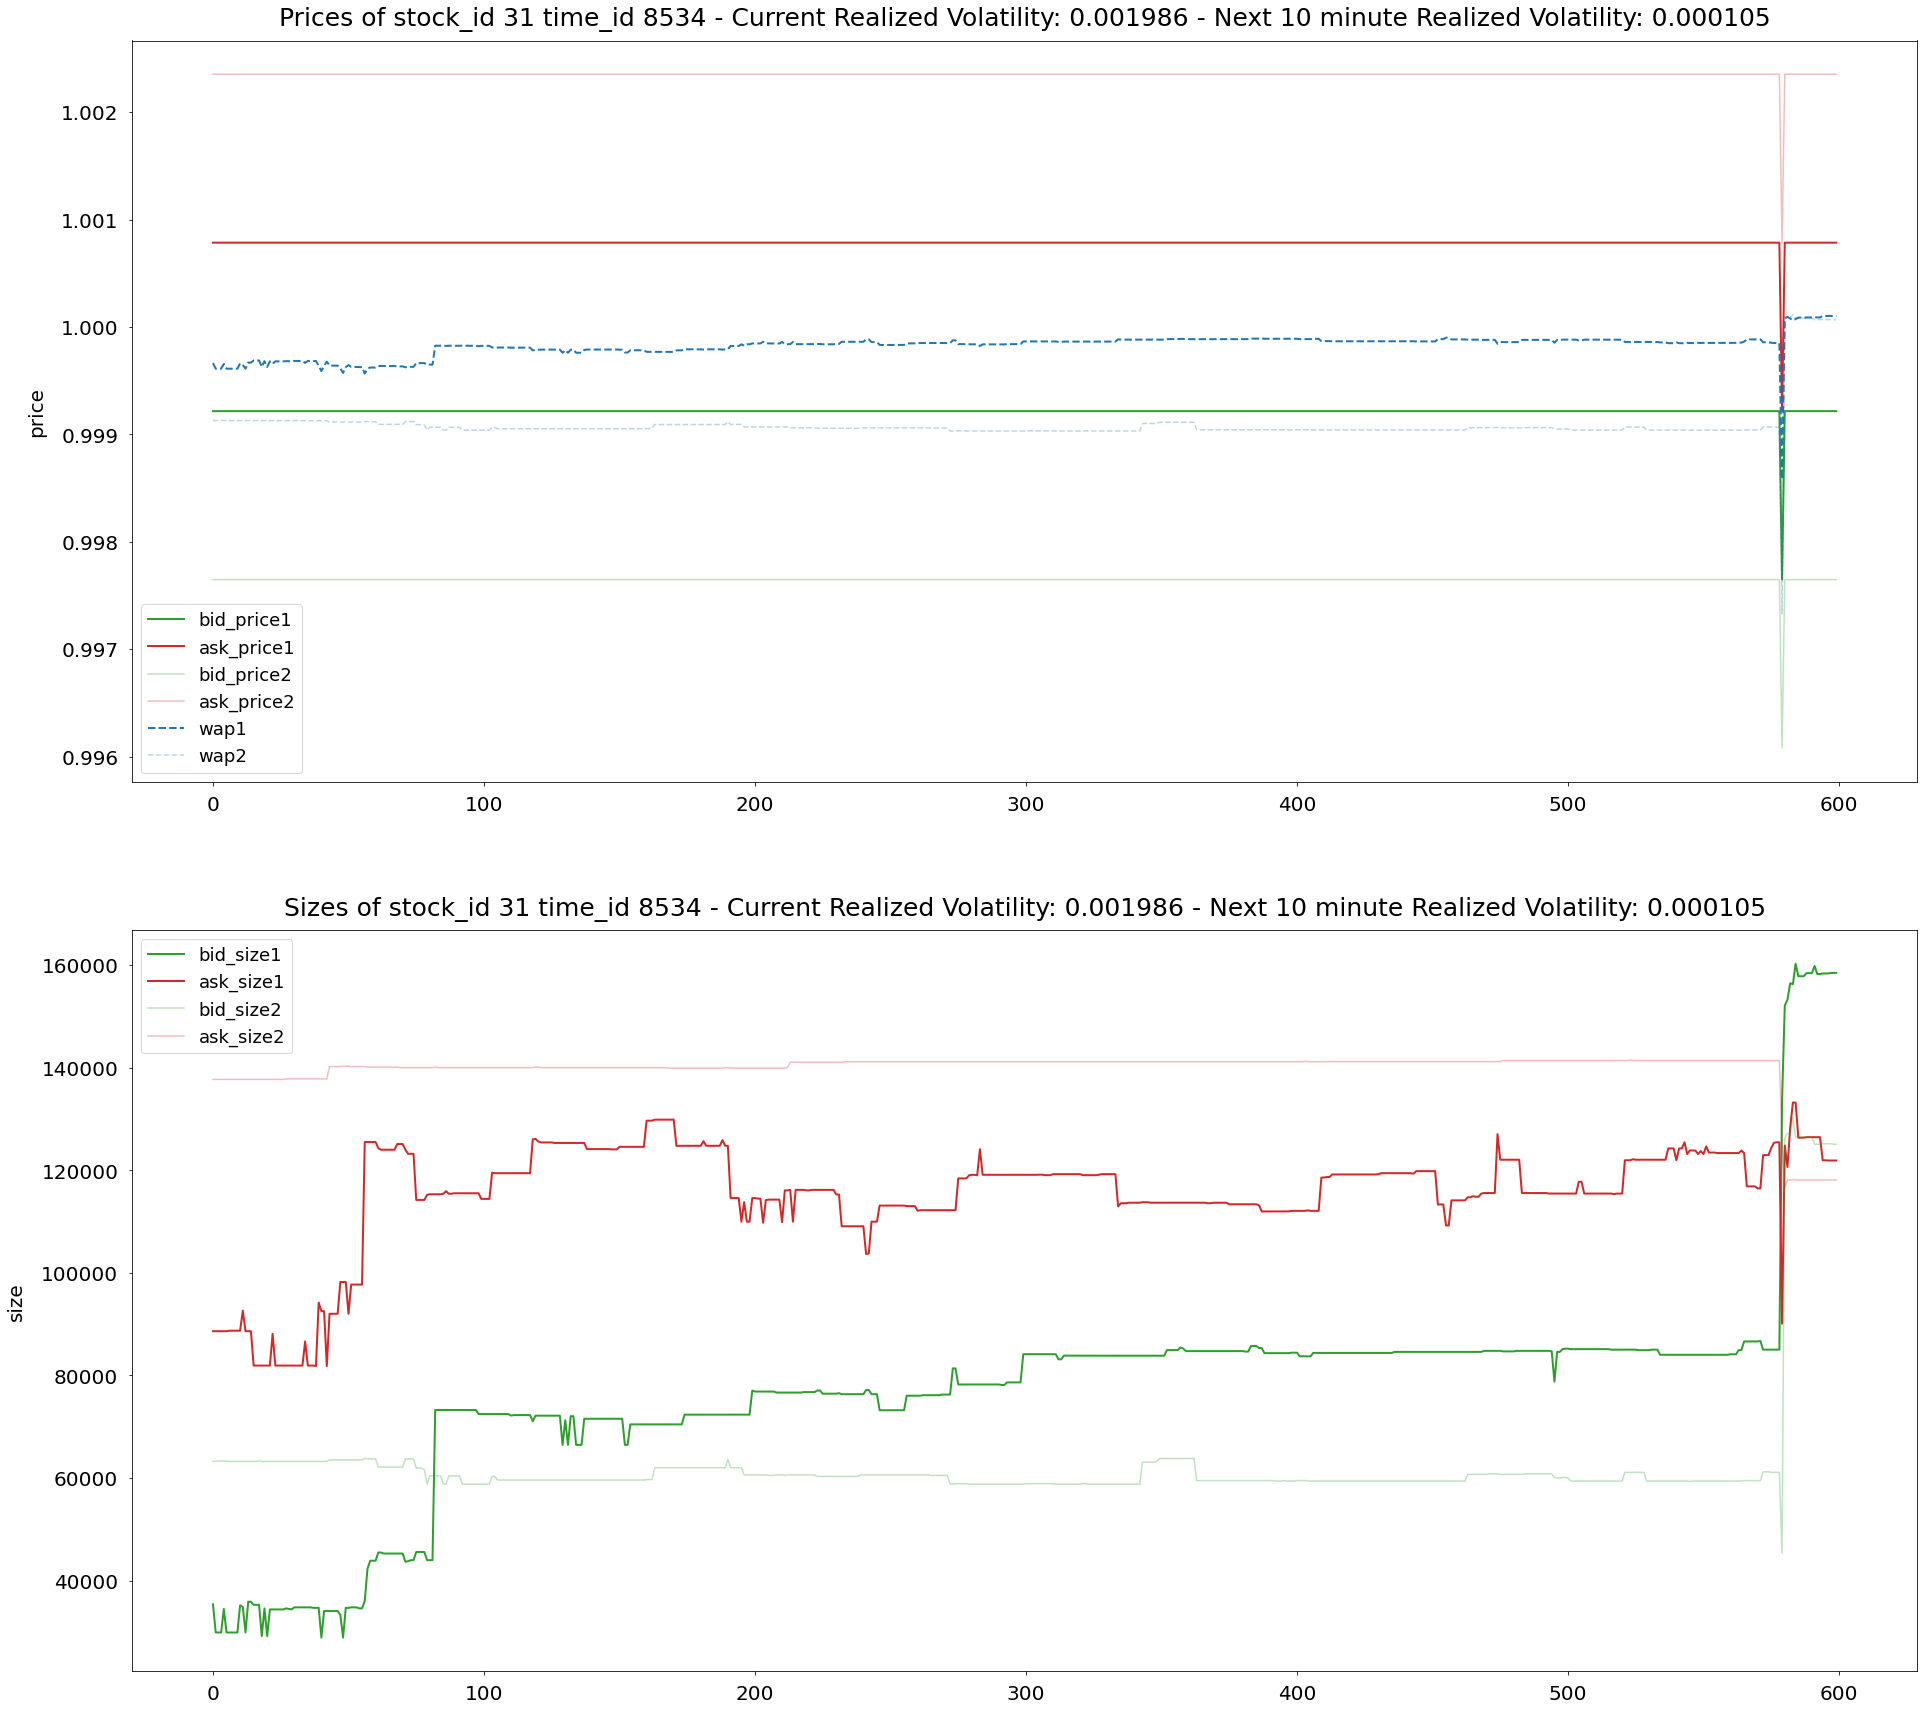

In [15]:
visualize_book_time_bucket(stock_id=31, time_id=8534)

The least volatile time bucket in current 10 minute window is time **28959** from stock **31**. Prices and sizes of most competitive bid and ask orders are exteremely balanced in this entire time bucket. Sizes of most competitive bid level is shifted to a new state at the second half. That movement slightly increased the weighted averaged price 1, and that was the only thing contributed to current realized volatility. Stock 31 is very calm compared to other stocks. Sizes of most competitive bid and ask levels could be the reason of this phenomenon, or it could be an anomaly.

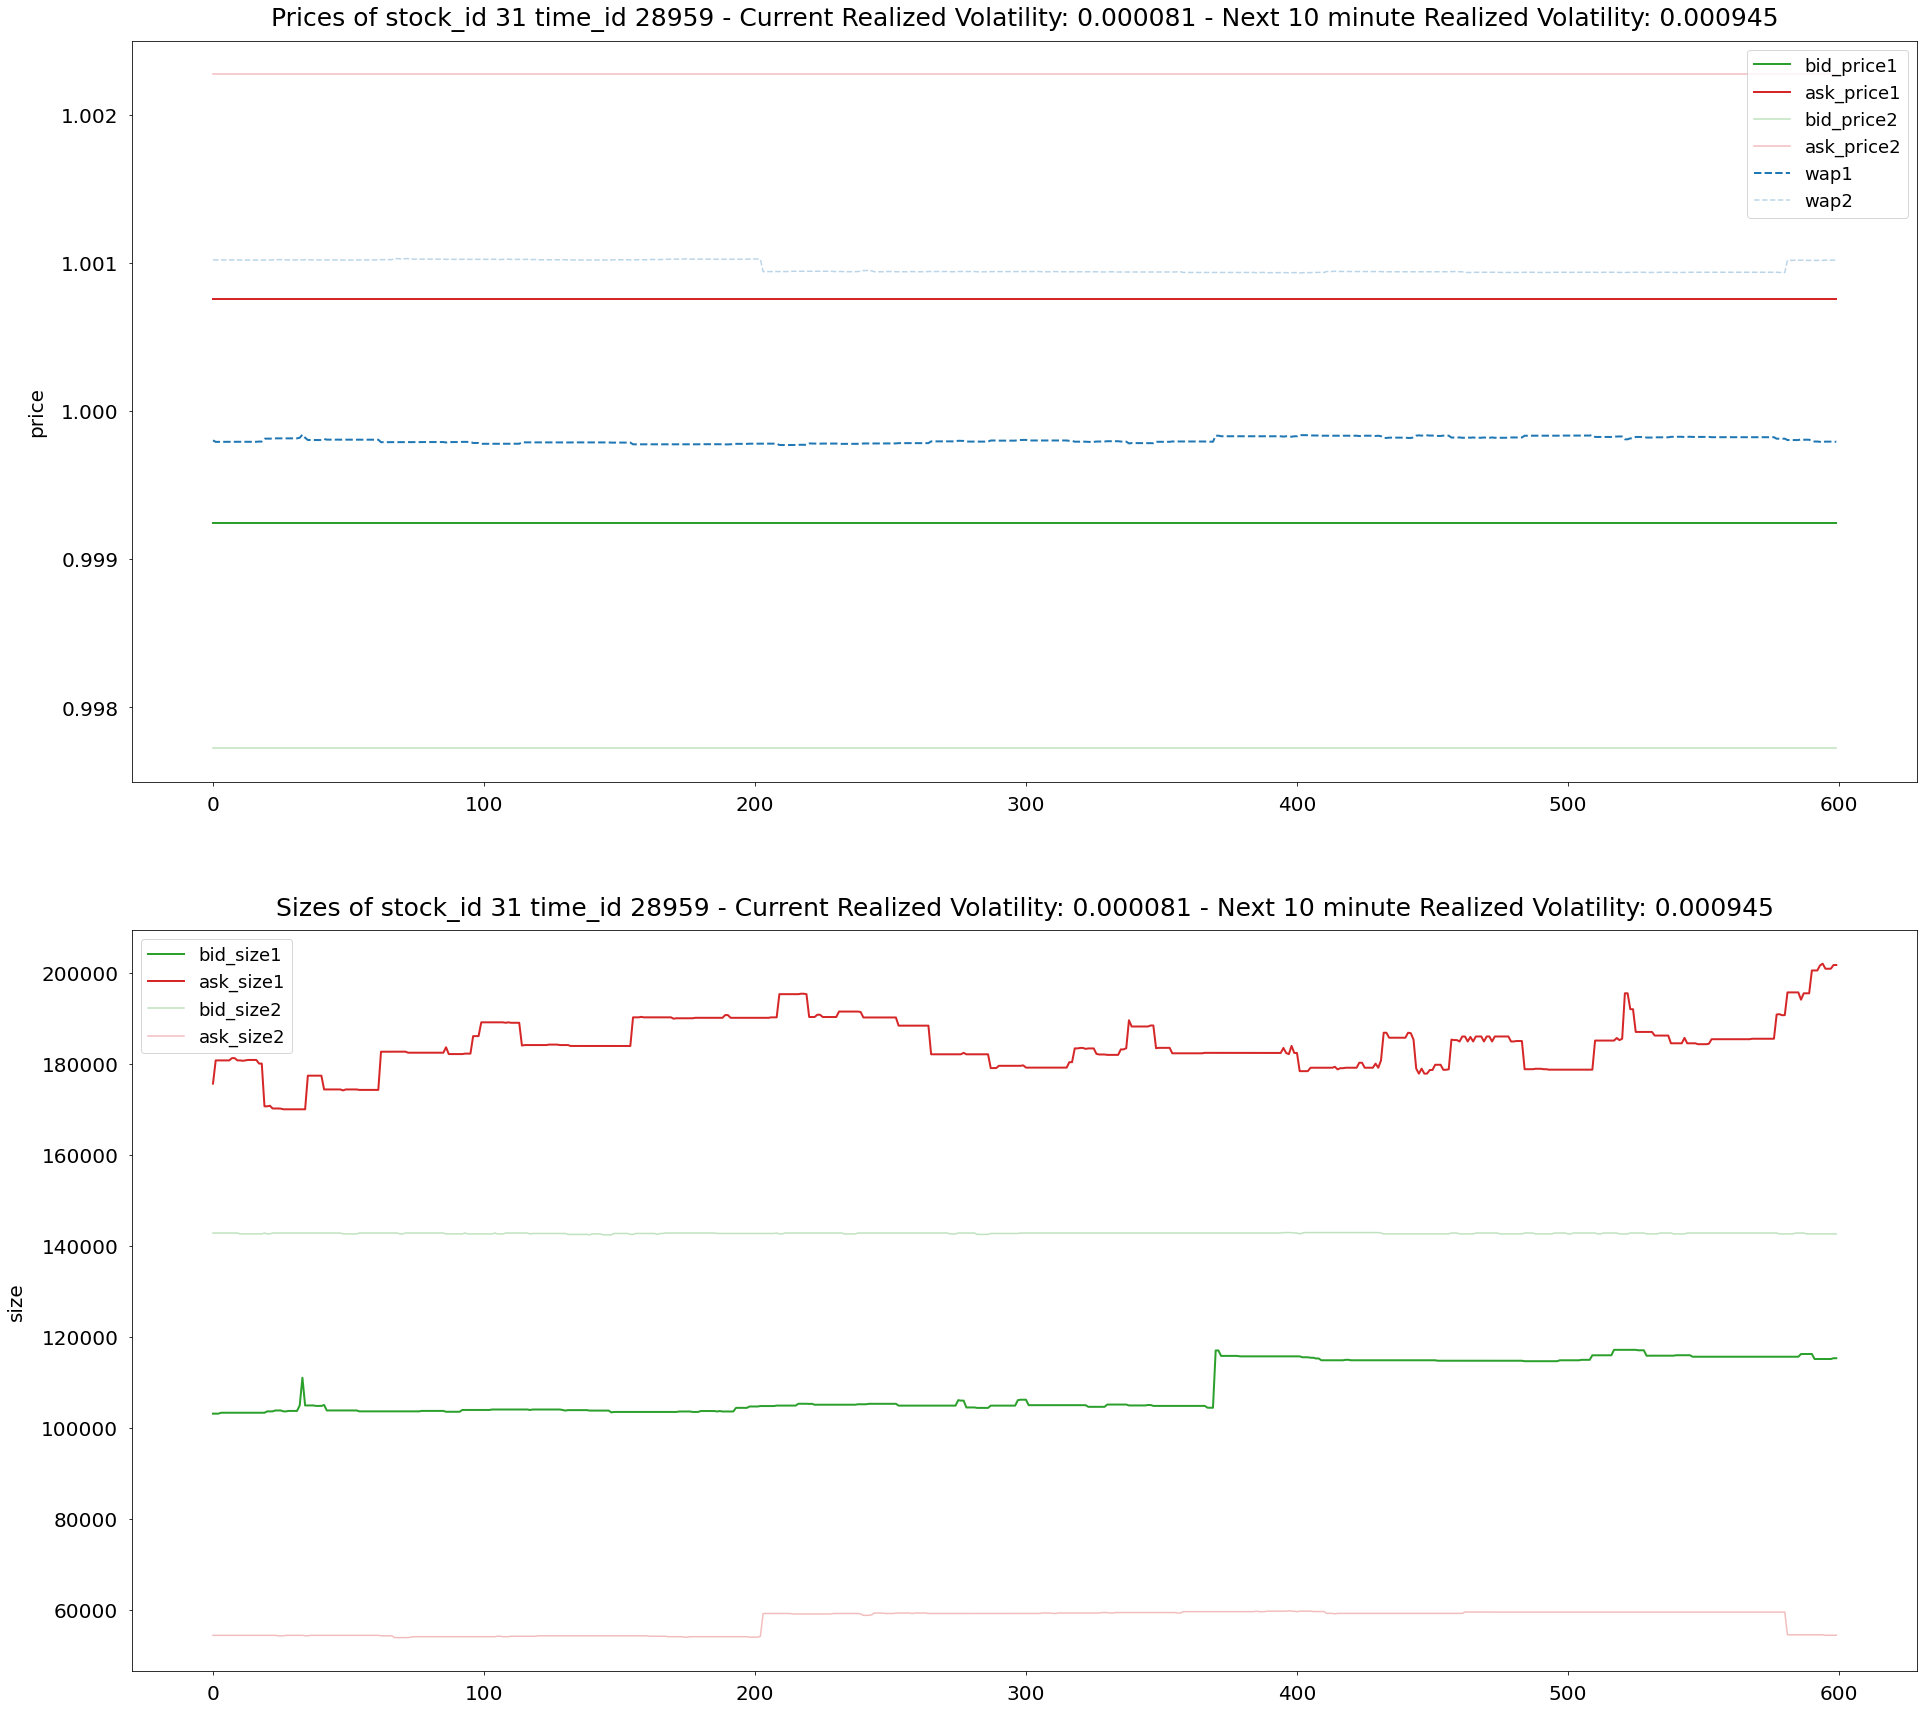

In [16]:
visualize_book_time_bucket(stock_id=31, time_id=28959)

To wrap up, order book is very important as it gives information about buy and sell orders at most competitive levels. Target is also derived from order books of the stocks, so features extracted from them will be very useful. Features that are capturing the price/size imbalances might be useful for models to predict realized volatilities of next 10 minute window.

## 5. Trade

Trade data represents the aggregation of all individual executed orders for corresponding stocks and time buckets. Size is the sum of the size in each individual order, price is aggregated as a weighted averaged price of all trades and order count is the number of unique trade orders taking place. For trade data, missing seconds_in_bucket implies no trade happening within that one second window.

Trade data files are named as `trade_train.parquet` and `trade_test.parquet`, and they are parquet files partitioned by stock_id column. Partitioned by stock_id means those files can both read as whole or individual stocks. However, reading them as a single file is not easy as they will consume too much memory.

There are 5 columns in every trade data partition. The columns are:

* `time_id` - ID of the time bucket
* `seconds_in_bucket` - Number of seconds passed since the start of the bucket
* `price` - Weighted average price of all executed trades happening in one second
* `size` - Total number of traded shares happening in one second
* `order_count` - Number of unique trade orders happening in one second

Trade data has lots of missing seconds_in_bucket as it is more sparse than order book. Besides, there are some missing time buckets in trade data which means there weren't any trades in that 10 minute window. In addition to that, seconds_in_bucket doesn't necessarily start from 0 in trade data. Trade data can be still reshaped into a fixed size by adding missing time buckets and reindexing time steps to 600 seconds. Missing values can be filled with zeros afterwards since there weren't any trades at those one second windows.

In [17]:
def read_trade_data(df, dataset, stock_id, sort=False, zero_fill=False):
        
    trade_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'price': np.float32,
        'size': np.uint16,
        'order_count': np.uint16
    }

    df_trade = pd.read_parquet(f'~/Documents/deep-learning/quant_course/kaggle_volatility/optiver-realized-volatility-prediction/trade_{dataset}.parquet/stock_id={stock_id}')
    
    if zero_fill:
        stock_time_buckets = df.loc[df['stock_id'] == stock_id, 'time_id'].reset_index(drop=True)
        missing_time_buckets = stock_time_buckets[~stock_time_buckets.isin(df_trade['time_id'])]
        df_trade = df_trade.merge(missing_time_buckets, how='outer')
    
    if sort:
        df_trade.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)
        
    if zero_fill:
        df_trade = df_trade.set_index(['time_id', 'seconds_in_bucket'])
        df_trade = df_trade.reindex(
            pd.MultiIndex.from_product([df_trade.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']),
        )
        df_trade.fillna(0, inplace=True)
        df_trade.reset_index(inplace=True)
    
    for column, dtype in trade_dtypes.items():
        df_trade[column] = df_trade[column].astype(dtype)

    return df_trade


Previously, realized volatilities were derived from weighted averaged price of the order book, but they can be derived from trade price as well since it is the weighted averaged price of the trade orders taking place. Realized volatilities derived from trade price are different from the previous ones because trade data is more sparse.

In [18]:
for stock_id in tqdm(sorted(df_train['stock_id'].unique())):
            
    df_trade = read_trade_data(df_train, 'train', stock_id)

    # Realized volatility
    for wap in [1, 2]:
        df_trade['log_return_from_price'] = np.log(df_trade['price'] / df_trade.groupby('time_id')['price'].shift(1))
        df_trade['squared_log_return_from_price'] = df_trade['log_return_from_price'] ** 2
        df_trade['realized_volatility_from_price'] = np.sqrt(df_trade.groupby('time_id')['squared_log_return_from_price'].transform('sum'))
        df_trade.drop(columns=['squared_log_return_from_price'], inplace=True)            
        realized_volatilities = df_trade.groupby('time_id')['realized_volatility_from_price'].first().to_dict()
        df_train.loc[df_train['stock_id'] == stock_id, 'realized_volatility_from_price'] = df_train[df_train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)


  0%|          | 0/112 [00:00<?, ?it/s]

Realized volatilies derived from trade price are used as baseline predictions. They score **0.380267** on training set. They can be used as predictors just like the realized volatilities derived from the order book.

In [19]:
realized_volatility_price_rmspe = root_mean_squared_percentage_error(df_train['target'], df_train['realized_volatility_from_price'])
print(f'Realized Volatility from price RMPSE: {realized_volatility_price_rmspe:.6}')

Realized Volatility from price RMPSE: 0.380267


Trade data tells how many shares are traded at what weighted averaged price by how many unique traders for every time step. Those traded shares are the ones listed in the order book at the corresponding time step. Oscillations of trade price, size and order count might be an indicator of realized volatility of the next 10 minute window. Another important thing to consider is sparsity. Sparsity indicates that the stock is calm and there aren't any trades taking place which could be a strong indicator of low realized volatility. However, it may not be a predictor of the next 10 minute windows' realized volatility. The function in the cell below is going to be used for visualizing individual trade data time buckets and trying to find clues about their volatilities. It is important to visualize every sequence with and without zeros in order to understand both oscillations and sparsity.

In [20]:
def visualize_trade_time_bucket(stock_id, time_id):
    
    time_bucket = (df_train['stock_id'] == stock_id) & (df_train['time_id'] == time_id)
    
    target = df_train.loc[time_bucket, 'target'].iloc[0]
    realized_volatility = df_train.loc[time_bucket, 'realized_volatility_from_wap1'].iloc[0]
    df_trade = read_trade_data(df_train, 'train', stock_id, sort=True, zero_fill=True)
    df_trade = df_trade.set_index('seconds_in_bucket')
    
    fig, axes = plt.subplots(figsize=(32, 70), nrows=6)
    
    axes[0].plot(df_trade.loc[(df_trade['time_id'] == time_id) & (df_trade['price'] != 0), 'price'], label='price without zeros', lw=2, linestyle='-', color='tab:blue')
    axes[1].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'price'], label='price with zeros', lw=2, linestyle='--', color='tab:blue')
    axes[2].plot(df_trade.loc[(df_trade['time_id'] == time_id) & (df_trade['price'] != 0), 'size'], label='size without zeros', lw=2, linestyle='-', color='tab:blue')
    axes[3].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'size'], label='size with zeros', lw=2, linestyle='--', color='tab:blue')
    axes[4].plot(df_trade.loc[(df_trade['time_id'] == time_id) & (df_trade['price'] != 0), 'order_count'], label='order_count without zeros', lw=2, linestyle='-', color='tab:blue')
    axes[5].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'order_count'], label='order_count with zeros', lw=2, linestyle='--', color='tab:blue')
    
    for i in range(6):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('price', size=20, labelpad=15)
    axes[2].set_ylabel('size', size=20, labelpad=15)
    axes[3].set_ylabel('size', size=20, labelpad=15)
    axes[4].set_ylabel('order_count', size=20, labelpad=15)
    axes[5].set_ylabel('order_count', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Price of stock_id {stock_id} time_id {time_id} without zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Price of stock_id {stock_id} time_id {time_id} with zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[2].set_title(
        f'Size of stock_id {stock_id} time_id {time_id} without zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[3].set_title(
        f'Size of stock_id {stock_id} time_id {time_id} with zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[4].set_title(
        f'Order count of stock_id {stock_id} time_id {time_id} without zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[5].set_title(
        f'Order count of stock_id {stock_id} time_id {time_id} with zeros - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    
    plt.show()


As seen before, the most volatile time bucket in next 10 minute window is time **24600** from stock **77**. Current realized volatility of that time bucket is 0.02 which is roughly greater than 99.7% of other current realized volatilities. Trade price without zeros is almost perfectly correlated with weighted averaged price from the order book and trade price with zeros shows that there are trades taking place very frequently. Size shows that there are some extreme amounts of shares traded at certain times by one or multiple traders. Finally, order count shows that there are large number of unique trade orders from time to time regardless of the total size and price.

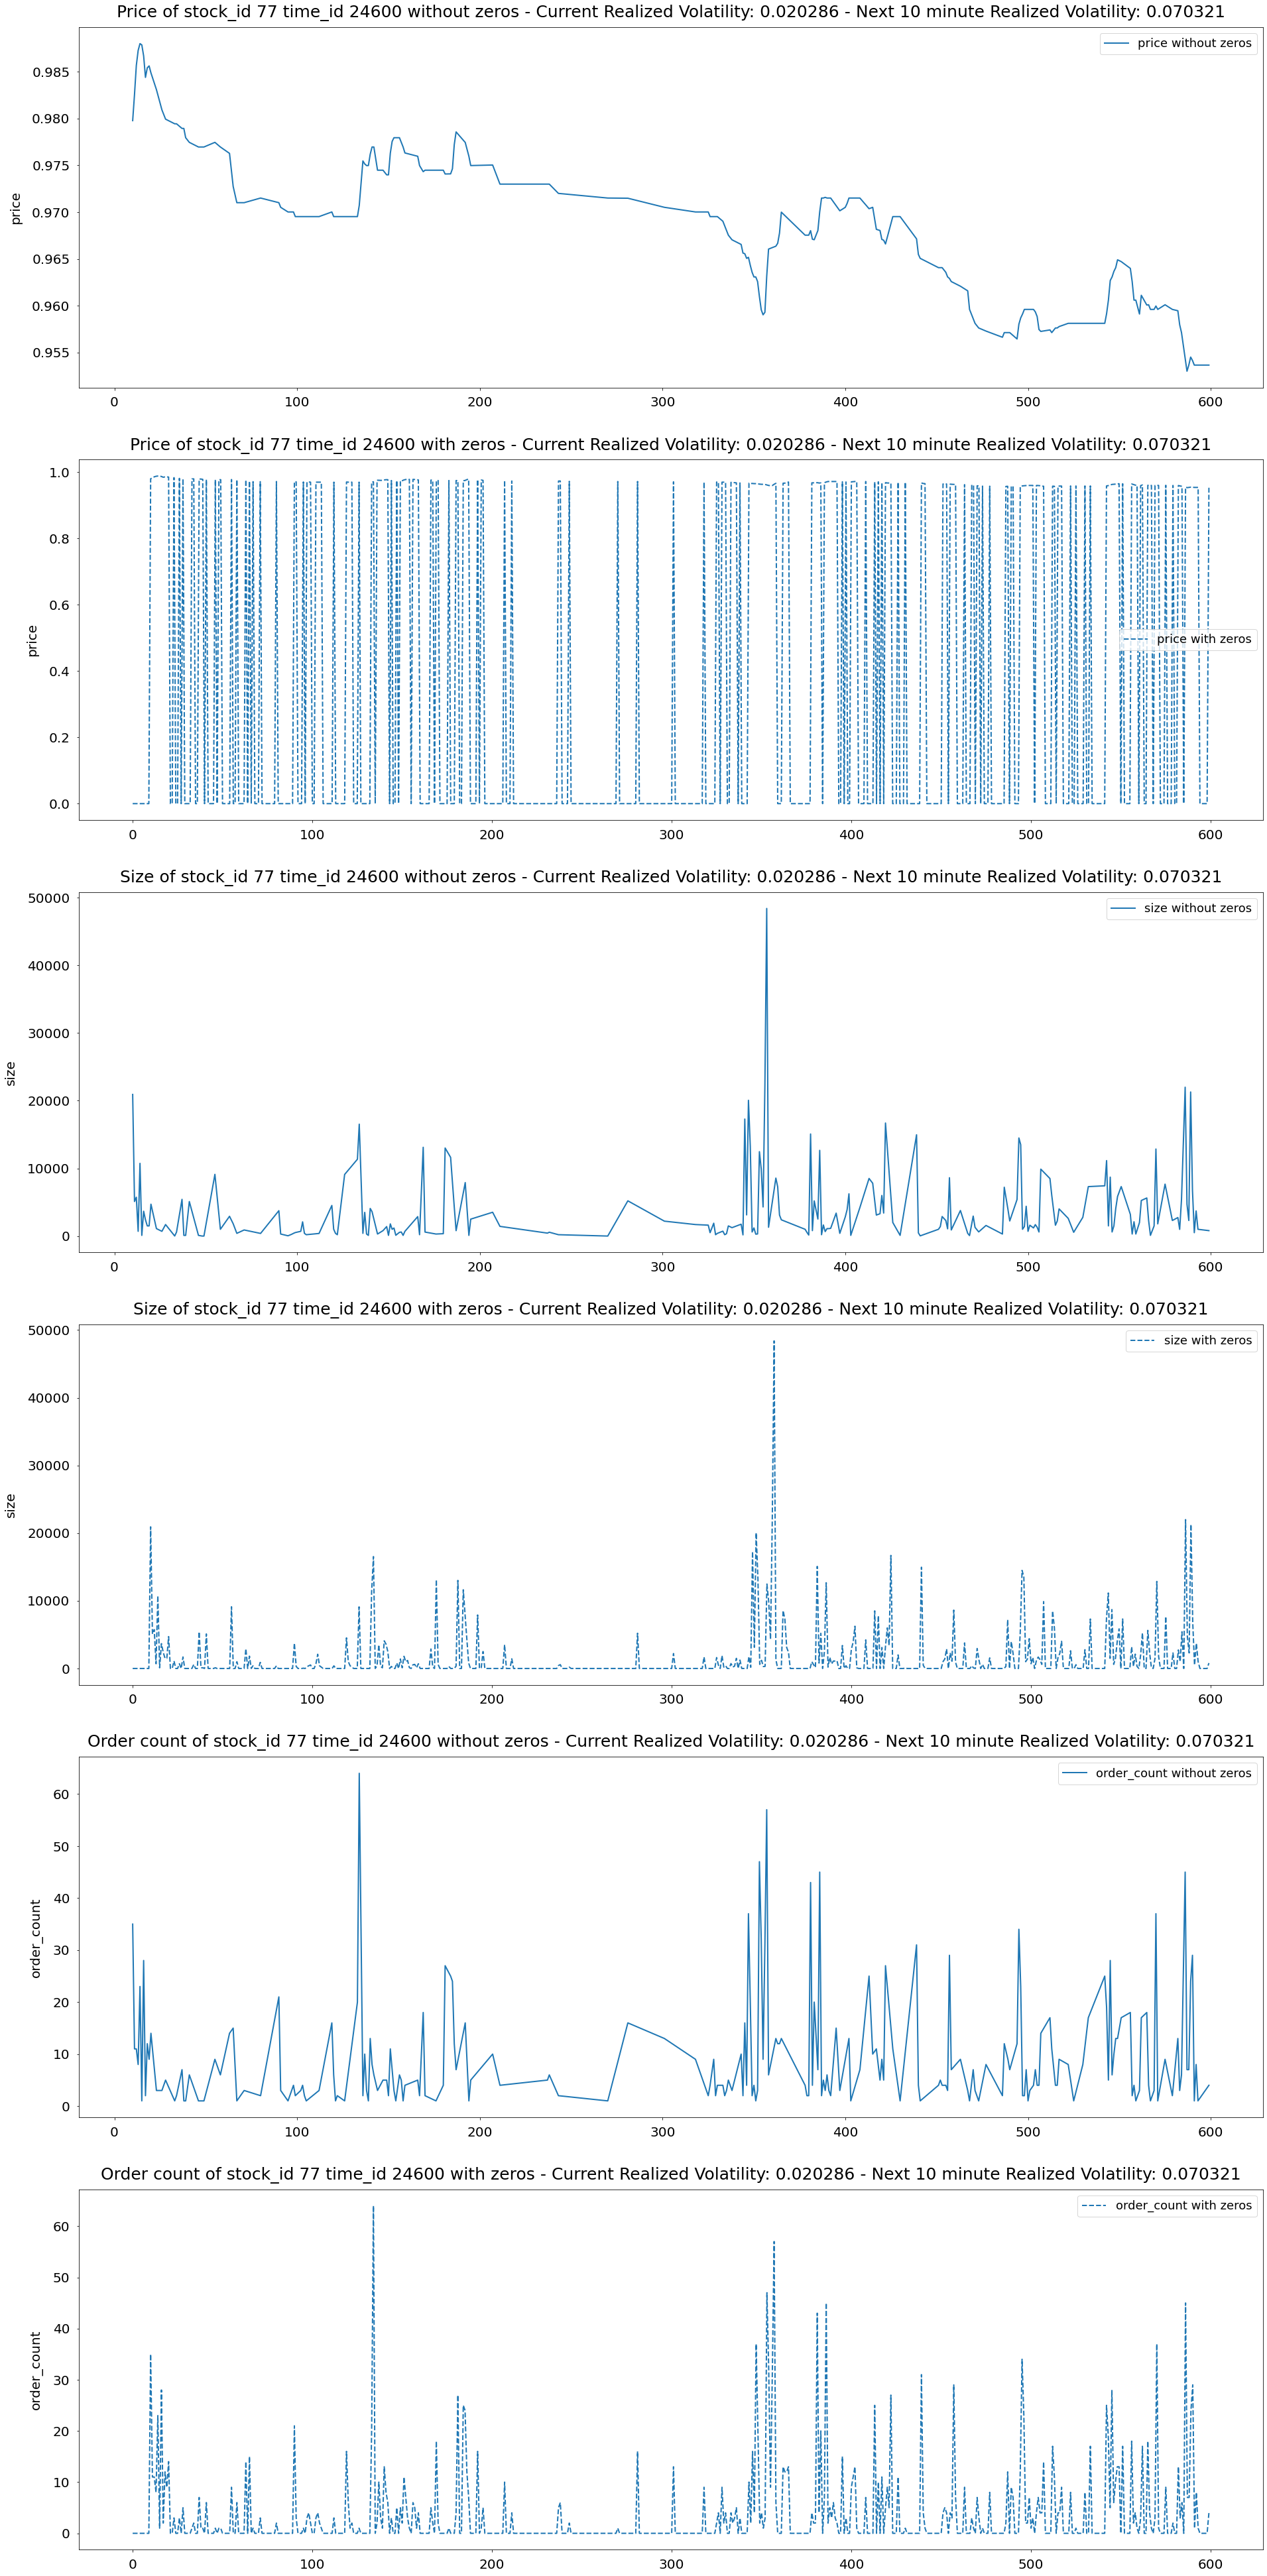

In [21]:
visualize_trade_time_bucket(stock_id=77, time_id=24600)

As seen before, the least volatile time bucket in next 10 minute window is time **8534** from stock **31**. There are only 4 trades took place in this time bucket which is why it's current realized volatility and next 10 minute window realized volatility is very low. Regardless of the values, sparsity is the obvious reason in this case. 

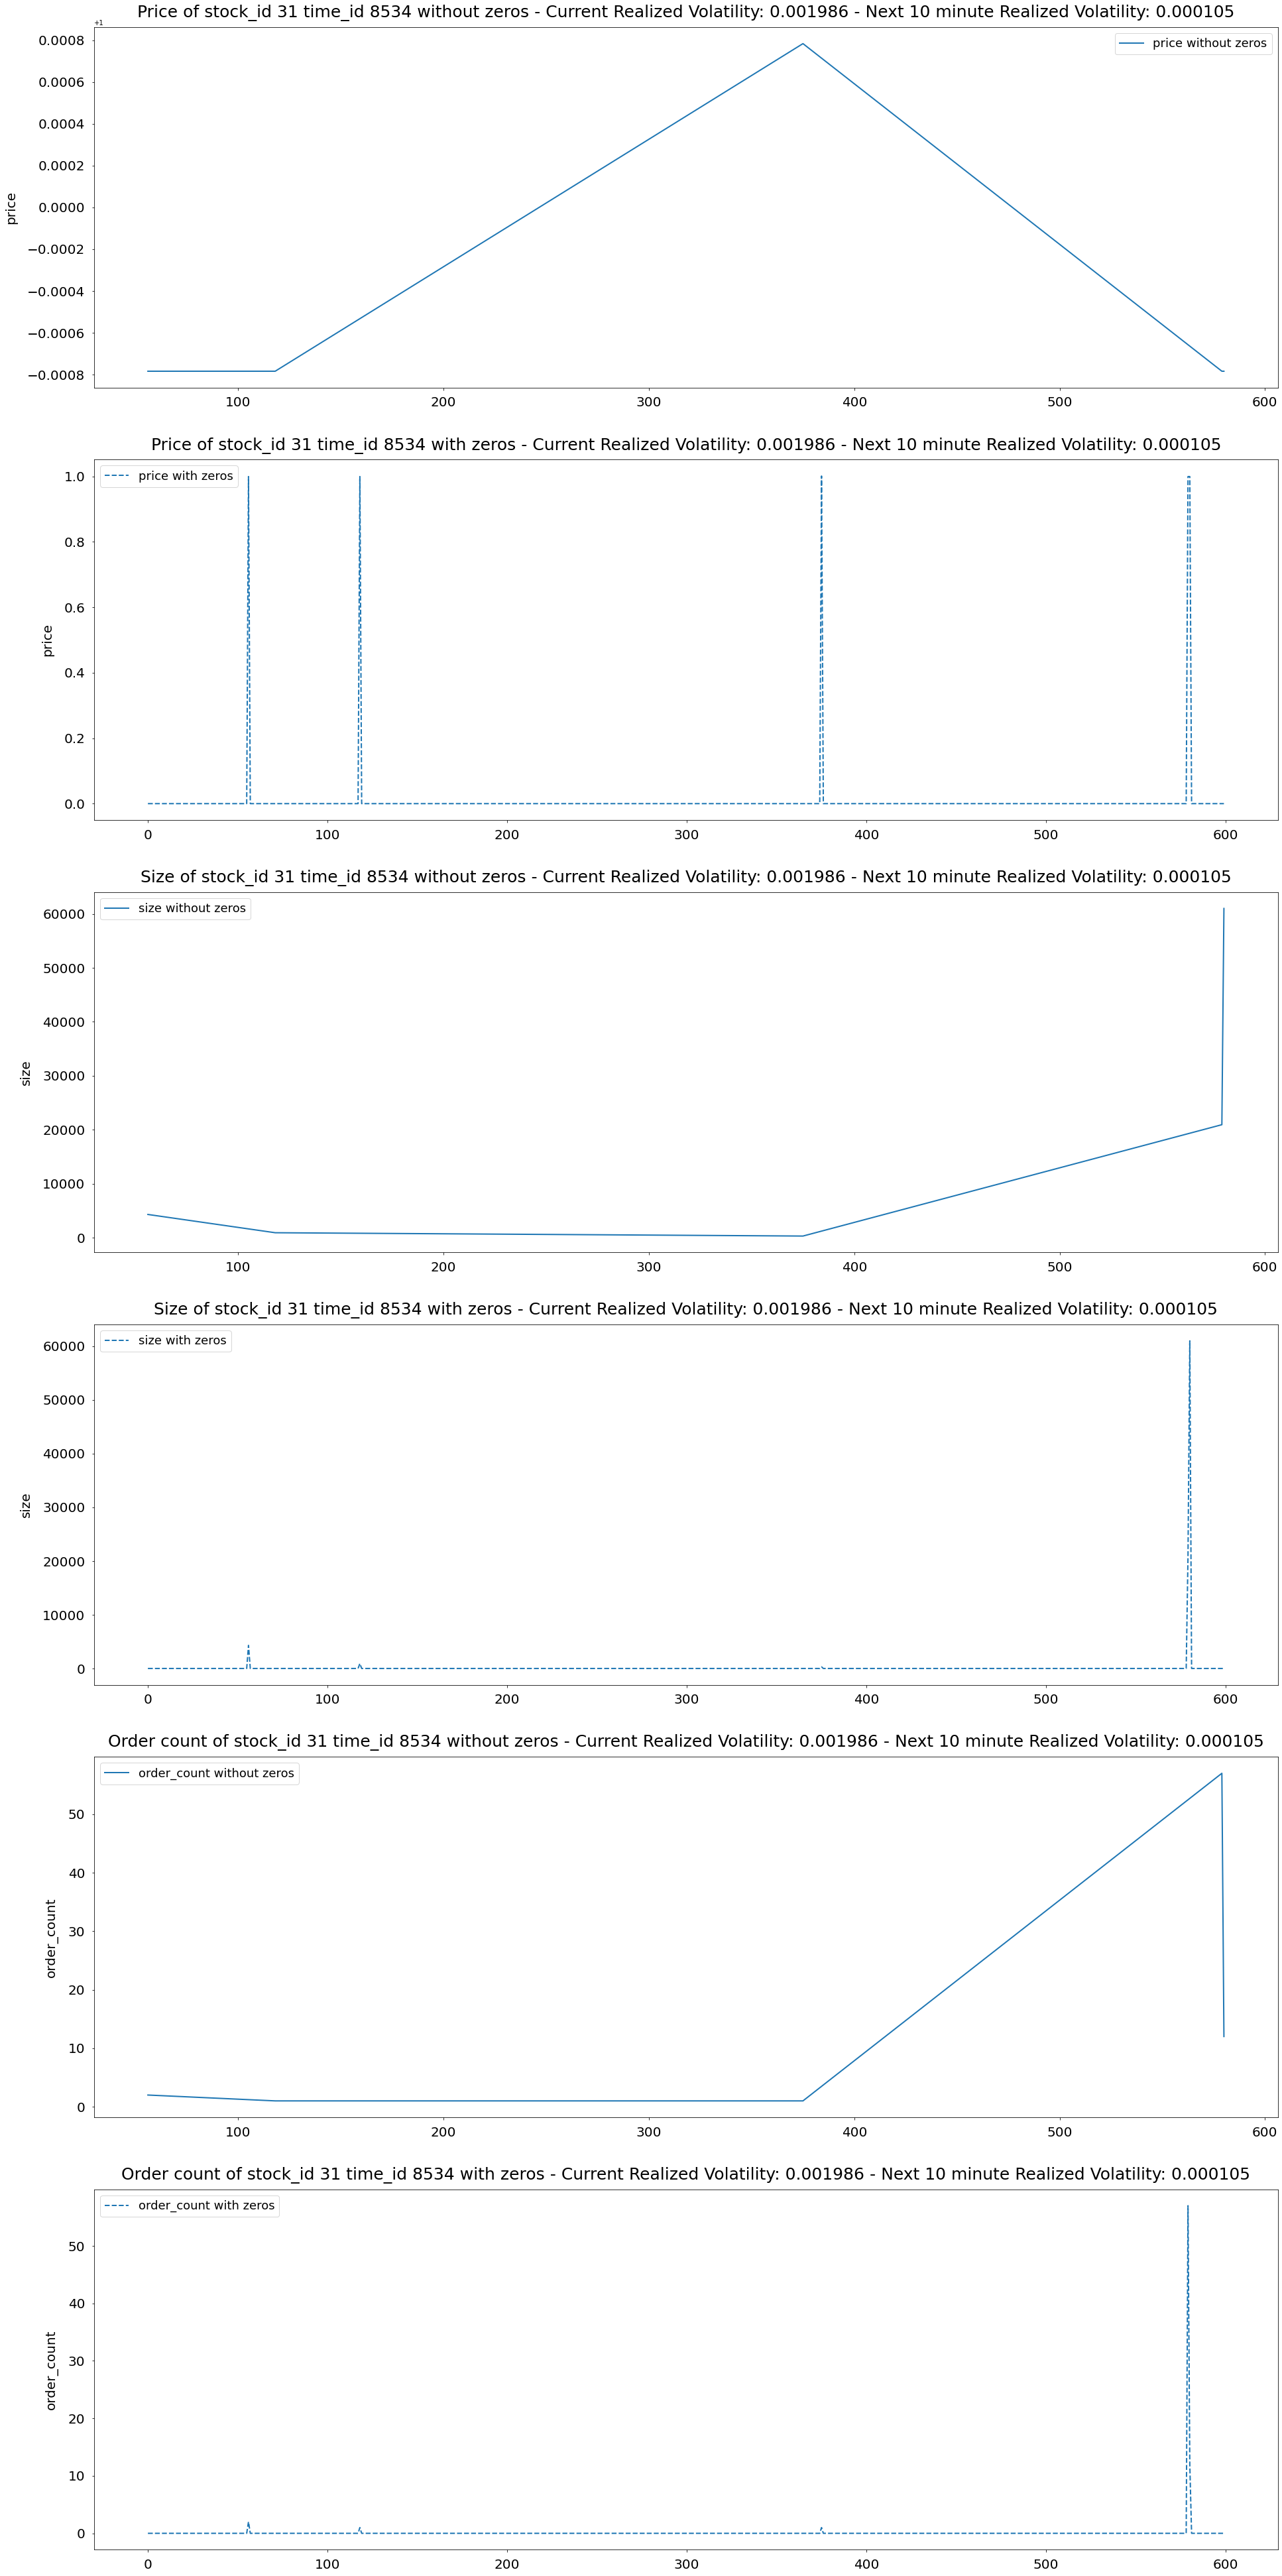

In [22]:
visualize_trade_time_bucket(stock_id=31, time_id=8534)

There are some time buckets with zero trades exist in trade data. Time **62** from stock **37** is an example of those time buckets. Those outliers should be handled differently from other stocks since they have empty trade data.

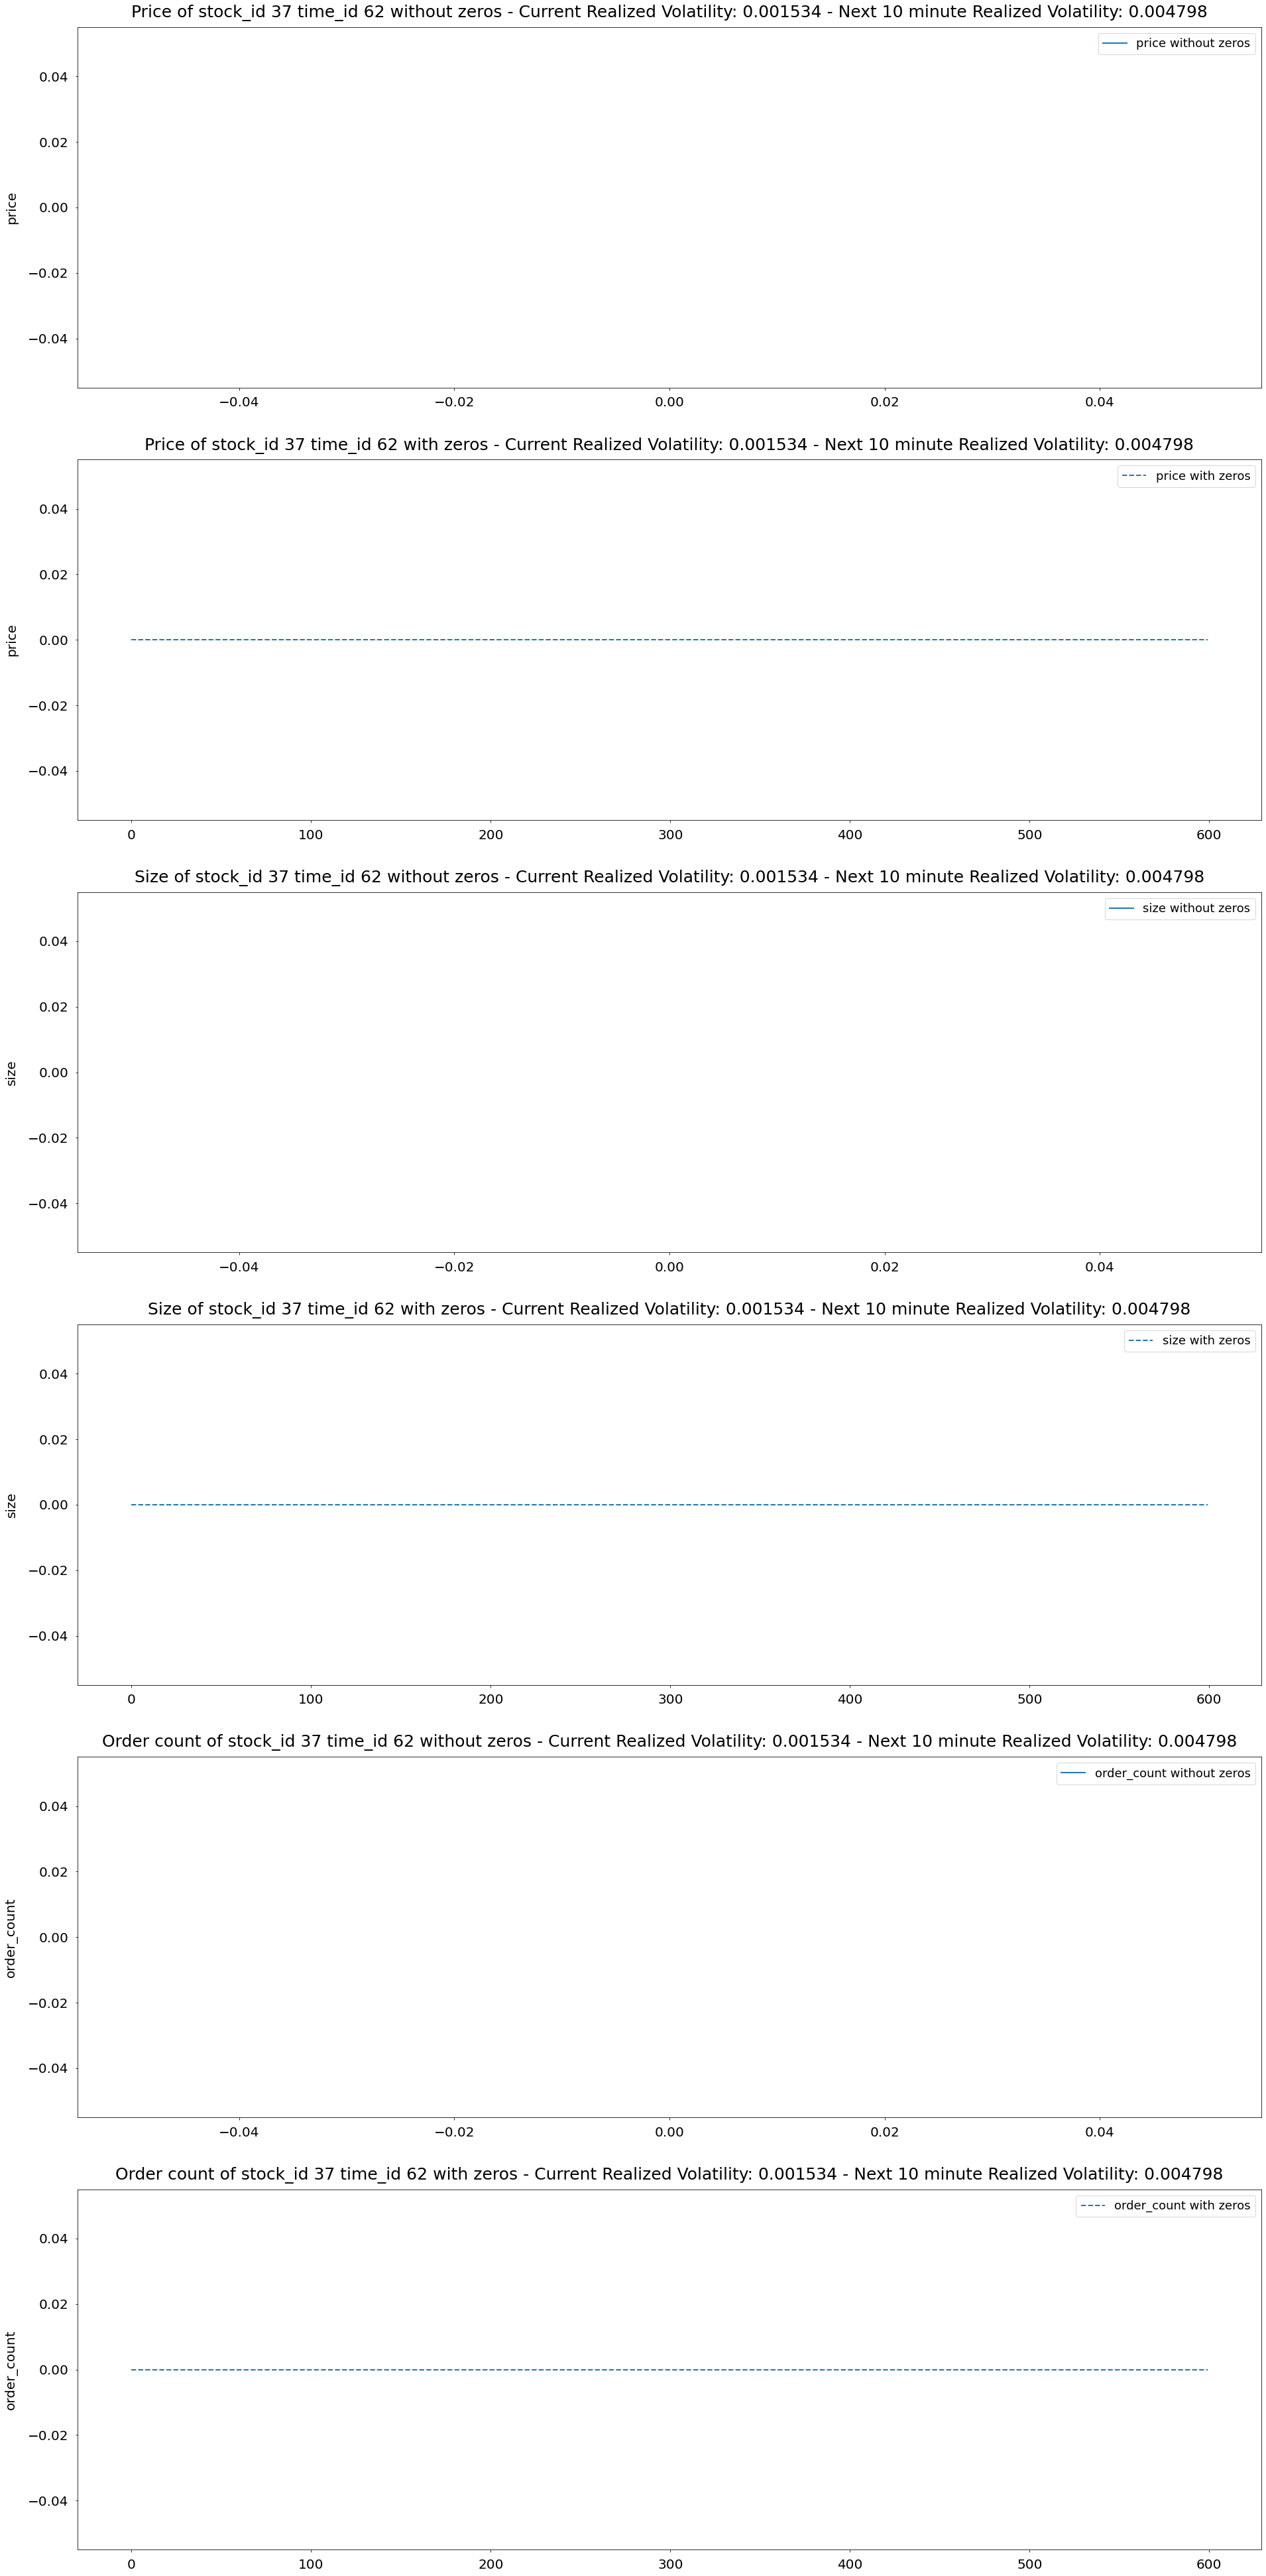

In [23]:
visualize_trade_time_bucket(stock_id=37, time_id=62)

## 6. Feature Engineering

In [24]:
# To Be Continued